In [3]:
from pathlib import Path

import polars as pl

from trade_analysis.ingress import load_trade_csv_v2
from trade_analysis.processing import compute_shares, compute_hhi, compute_product_weights
from trade_analysis.charts.pie import plot_pie
from trade_analysis.charts.line import plot_share_over_time
from trade_analysis.charts.bar import plot_bar
from trade_analysis.charts.hhi import plot_hhi_over_time
from trade_analysis.hypothesis_testing import screen_share_breaks, screen_hhi_breaks, compare_breakpoints
from trade_analysis.charts.trends import plot_segmented_trend, plot_hypothesis_summary

In [4]:
df = load_trade_csv_v2(Path("data/hs30.csv"))
result = compute_shares(df)
hhi = compute_hhi(result)
print(result)
print(hhi)

shape: (9_296, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ partner_c ┆ partner_n ┆ product_c ┆ product_n ┆ … ┆ yoy_chang ┆ ma_3y     ┆ is_signif ┆ was_sign │
│ ode       ┆ ame       ┆ ode       ┆ ame       ┆   ┆ e_percent ┆ ---       ┆ icant     ┆ ificant  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ i64       ┆ str       ┆   ┆ f64       ┆           ┆ bool      ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AD        ┆ Andorra   ┆ 30        ┆ PHARMACEU ┆ … ┆ null      ┆ null      ┆ false     ┆ null     │
│           ┆           ┆           ┆ TICAL     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ PRODUCTS  ┆   ┆           ┆           ┆           ┆          │
│ AD        ┆ Andorra   ┆ 30        ┆ PHARMACEU ┆ … ┆ 36.307927 ┆ 217226

In [5]:
weights = compute_product_weights(result, baseline_end=2019)
print(weights)

min_weight = 2.5
relevant_codes = weights.filter(pl.col("weight_pct") >= min_weight)["product_code"].to_list()
result_f = result.filter(pl.col("product_code").is_in(relevant_codes))
hhi_f = hhi.filter(pl.col("product_code").is_in(relevant_codes))
print(f"Subchapters >= {min_weight}% weight: {len(relevant_codes)} of {weights.height}")

shape: (6, 4)
┌──────────────┬─────────────────────────────────┬─────────────┬────────────┐
│ product_code ┆ product_name                    ┆ total_value ┆ weight_pct │
│ ---          ┆ ---                             ┆ ---         ┆ ---        │
│ i64          ┆ str                             ┆ f64         ┆ f64        │
╞══════════════╪═════════════════════════════════╪═════════════╪════════════╡
│ 3004         ┆ Medicaments consisting of mixe… ┆ 2.2896e11   ┆ 53.33494   │
│ 3002         ┆ Human blood; animal blood prep… ┆ 1.5492e11   ┆ 36.087864  │
│ 3003         ┆ Medicaments consisting of two … ┆ 2.4268e10   ┆ 5.653018   │
│ 3006         ┆ Pharmaceutical preparations an… ┆ 8.1956e9    ┆ 1.909125   │
│ 3001         ┆ Dried glands and other organs … ┆ 6.5677e9    ┆ 1.529917   │
│ 3005         ┆ Wadding, gauze, bandages and t… ┆ 6.3755e9    ┆ 1.485136   │
└──────────────┴─────────────────────────────────┴─────────────┴────────────┘
Subchapters >= 2.5% weight: 3 of 6


In [10]:
product_codes = result["product_code"].unique().sort()
analysis_years = result["time_period"].unique().sort()

print("Product codes:", product_codes.to_list())
print("Years:", analysis_years.to_list())

Product codes: [30, 3001, 3002, 3003, 3004, 3005, 3006]
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


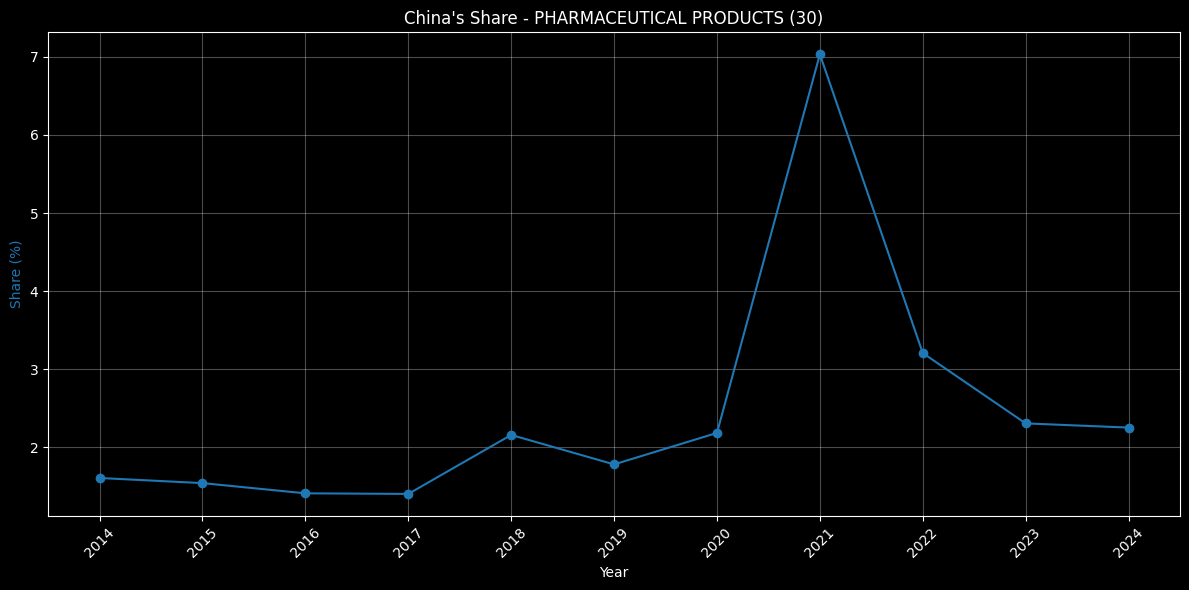

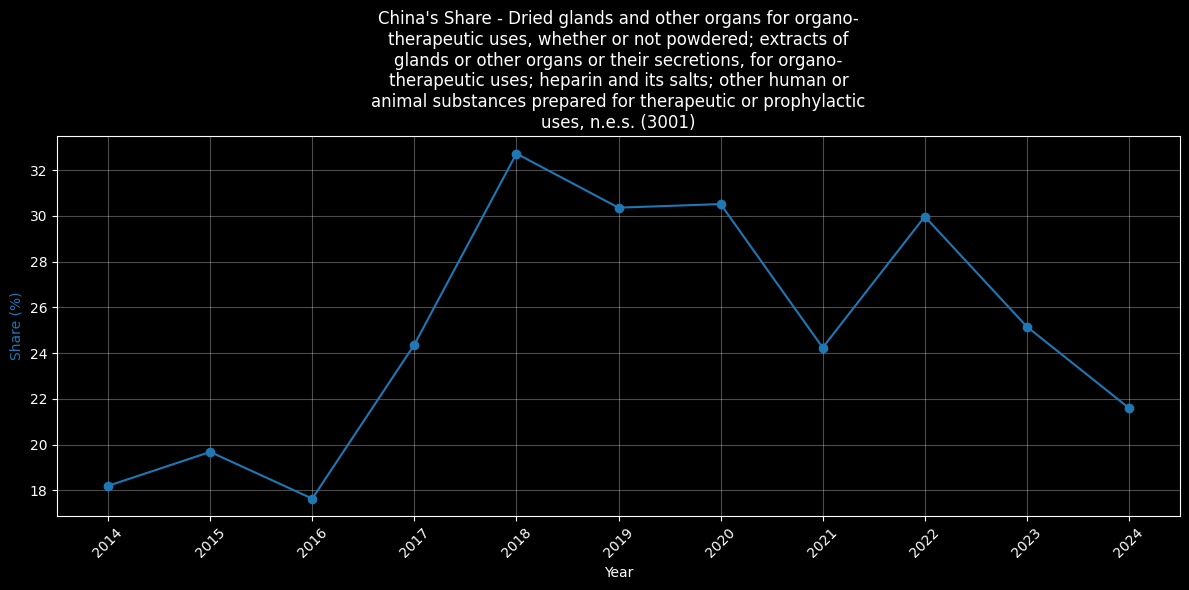

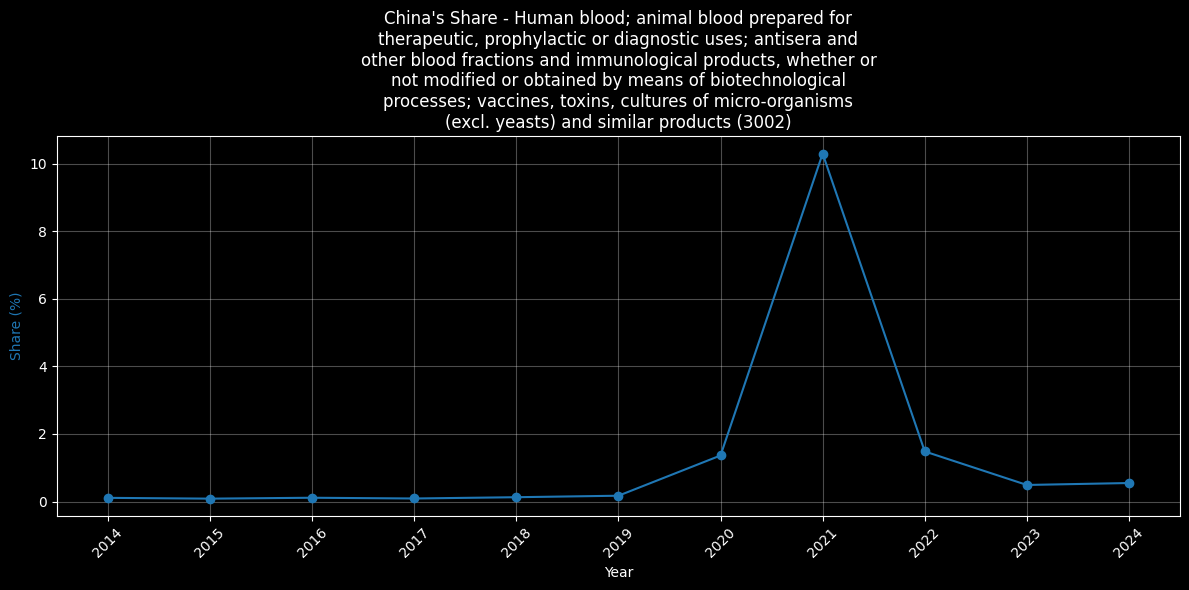

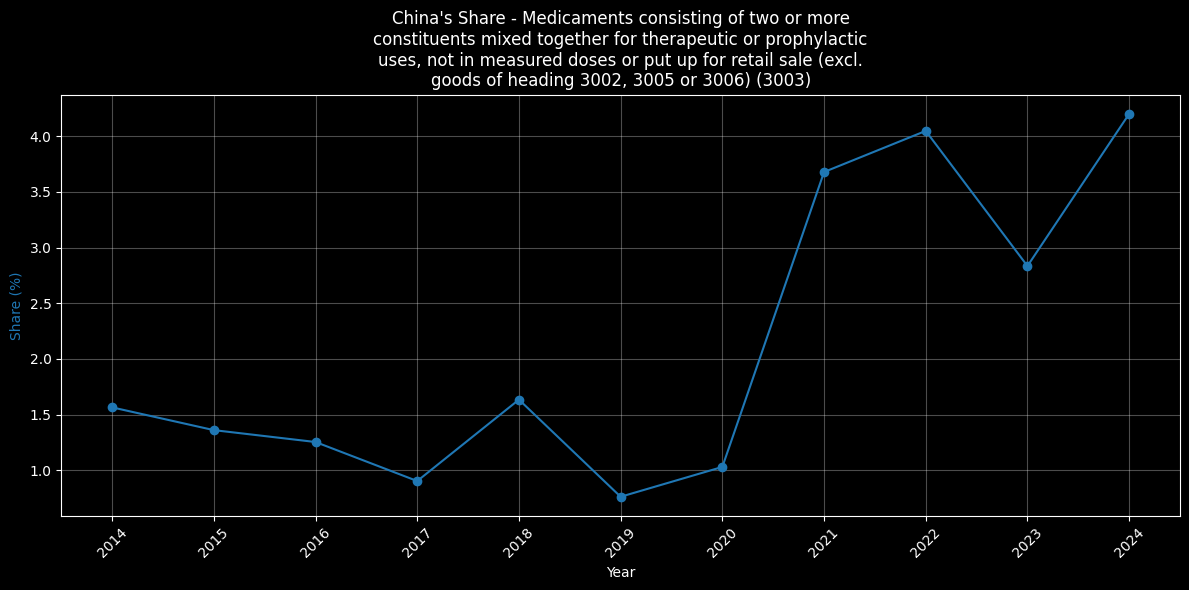

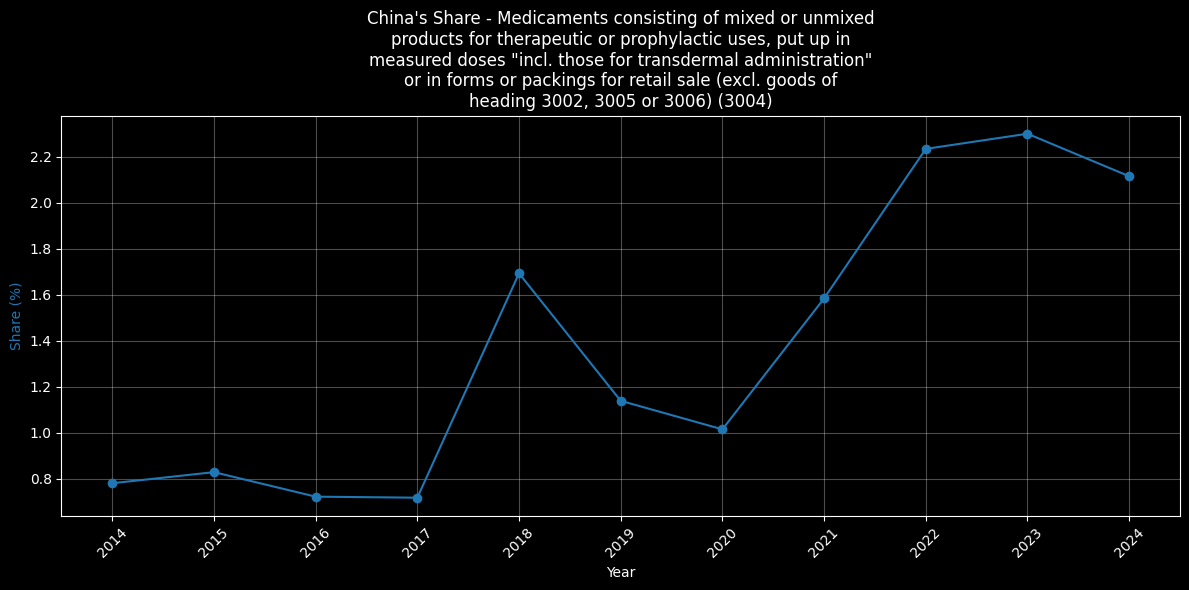

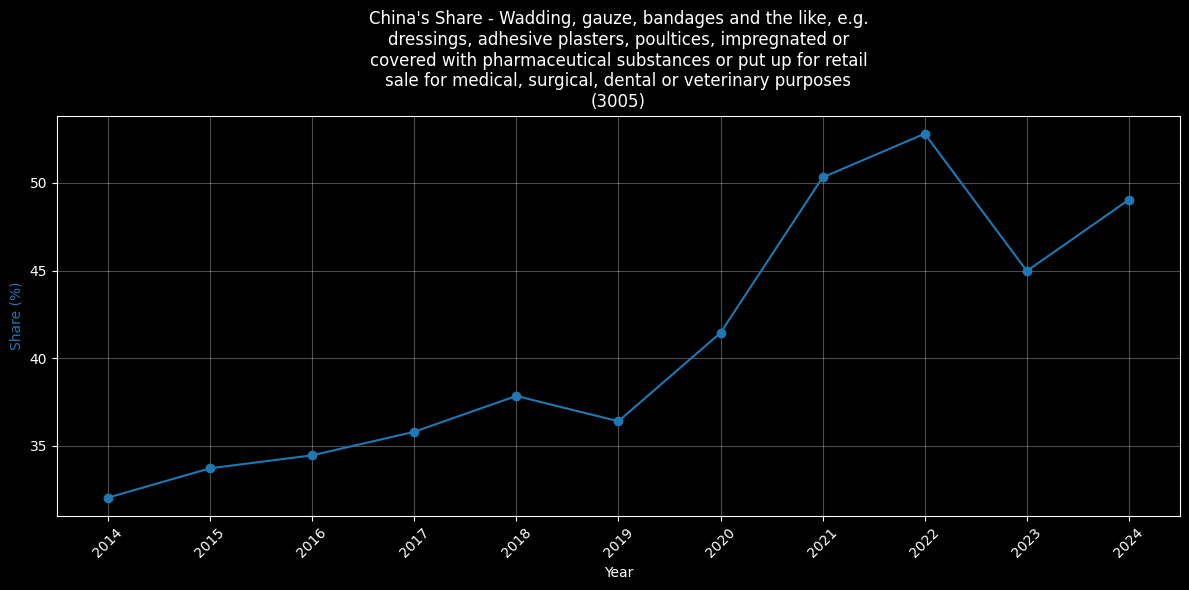

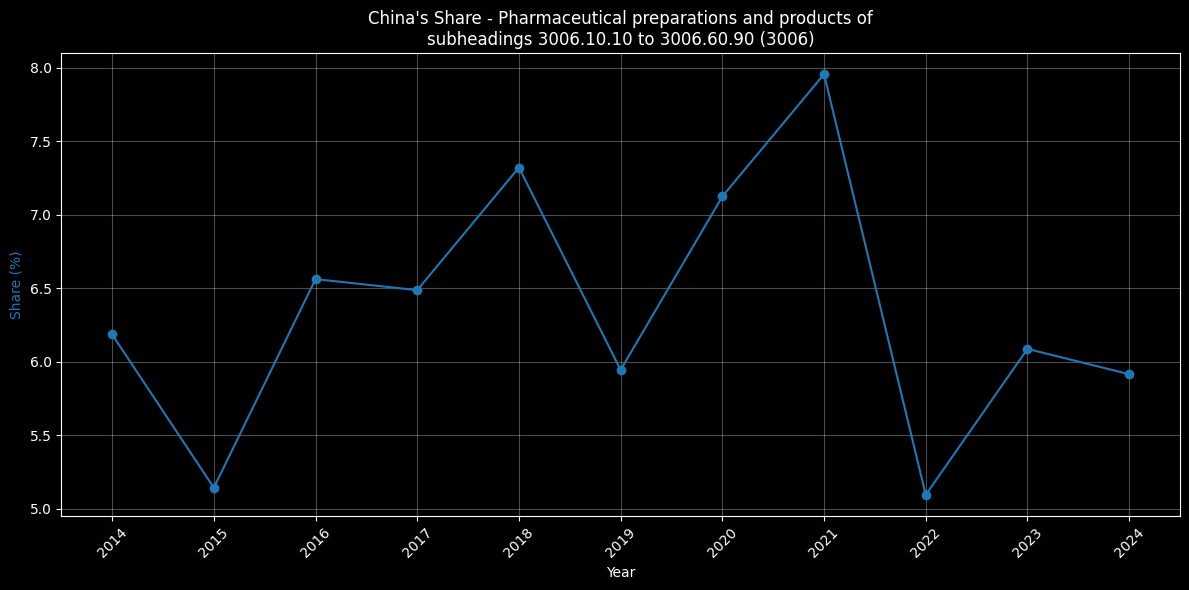

In [11]:
# Line chart: China's share over time for each product
for code in product_codes:
    plot_share_over_time(result, code, partner_code="CN")

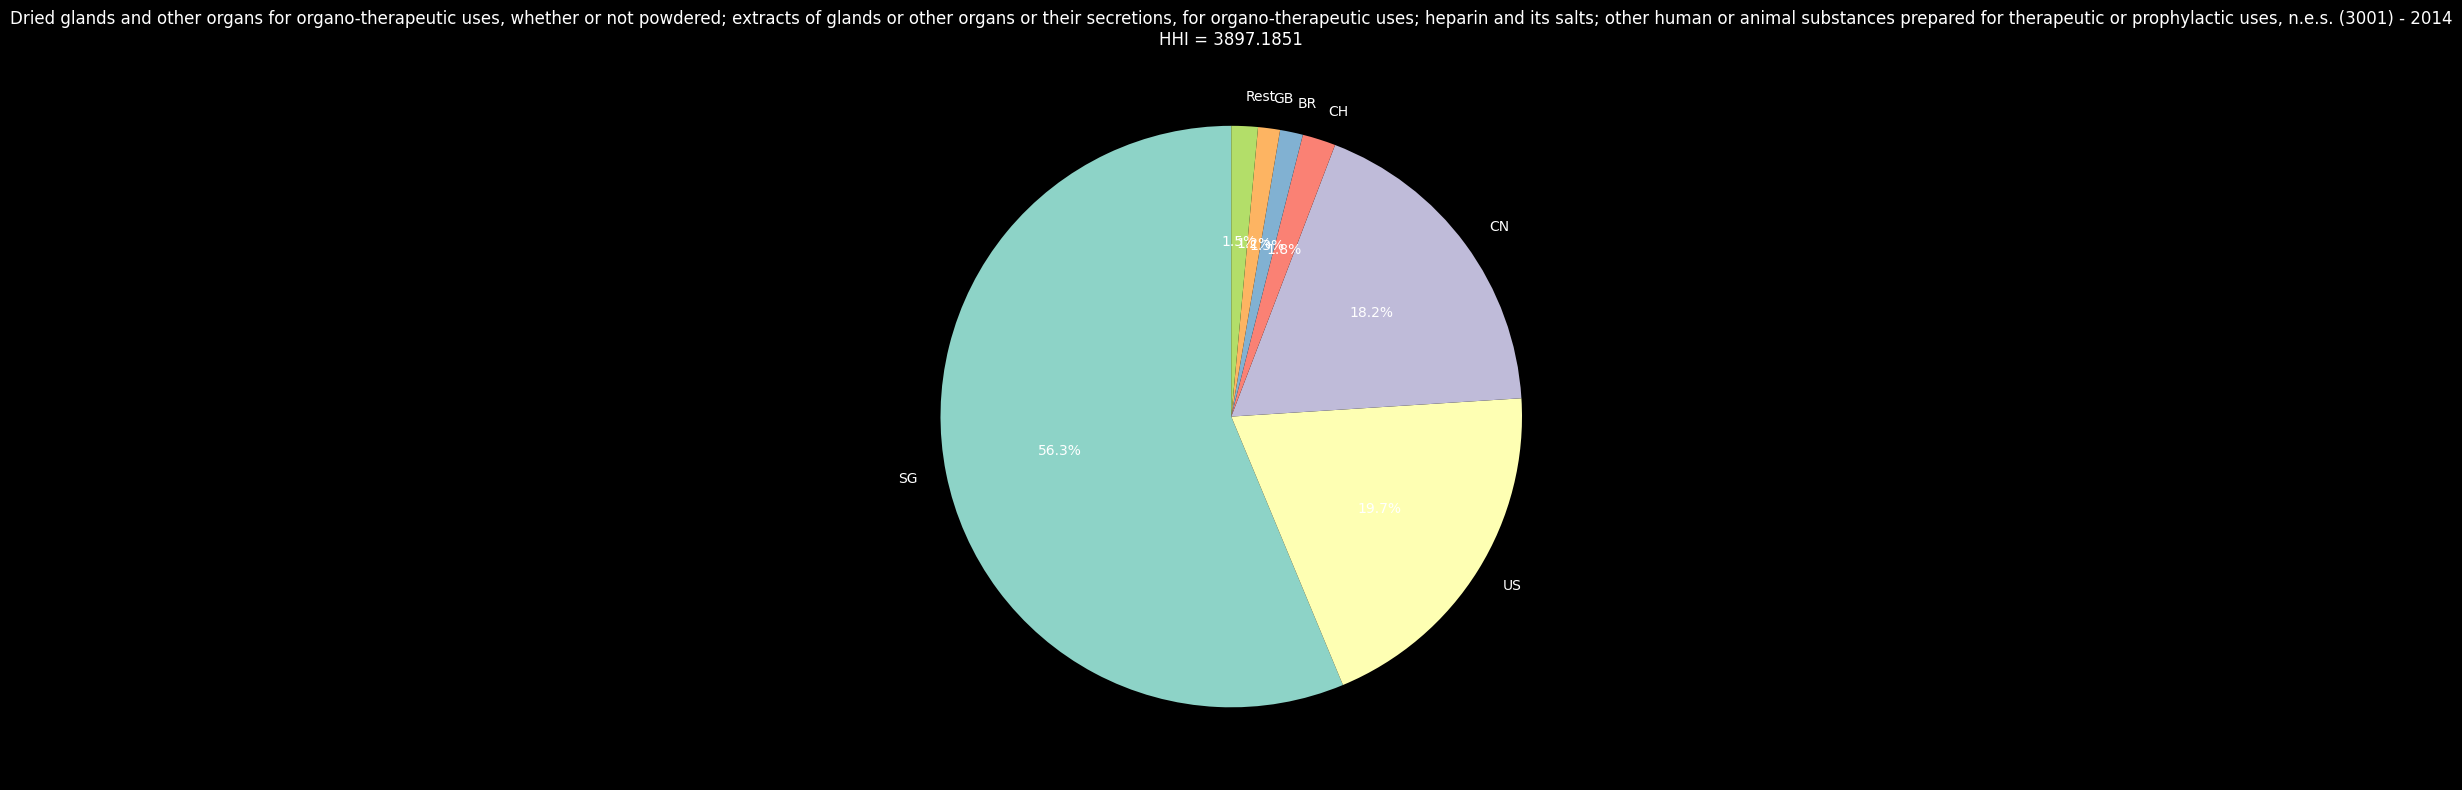

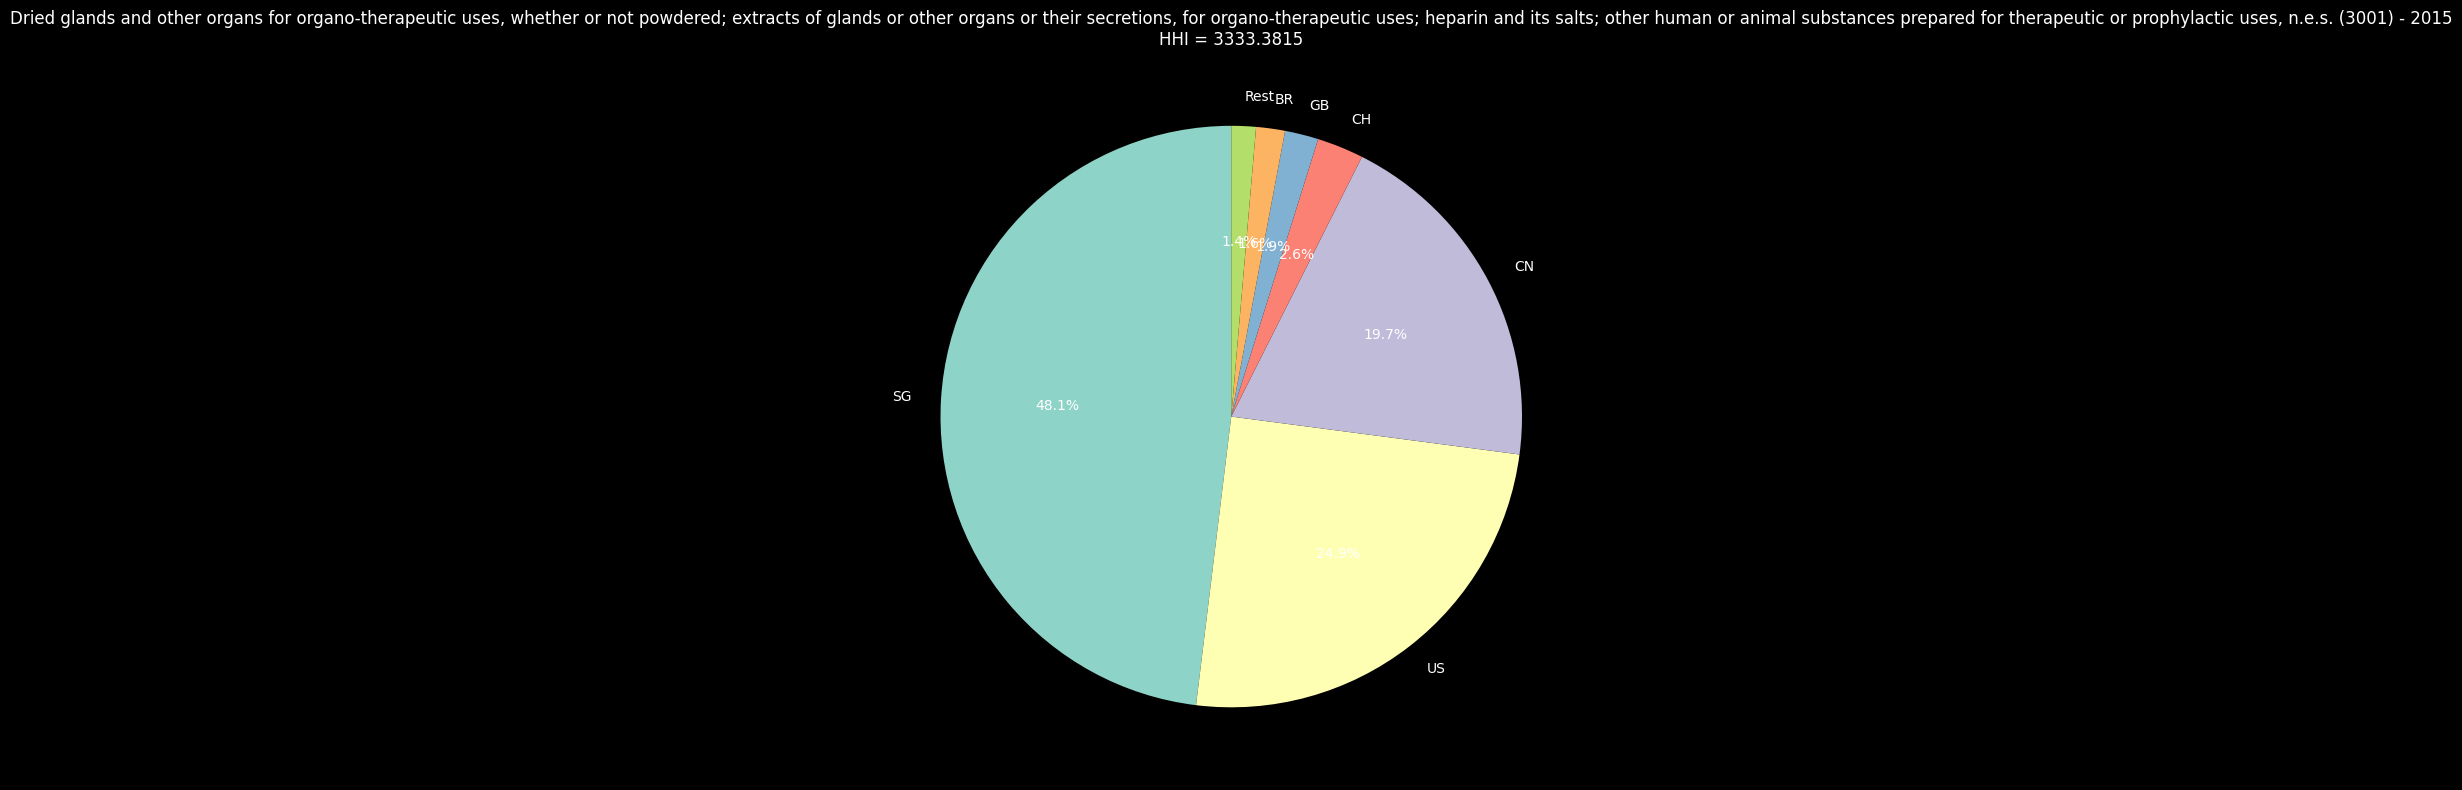

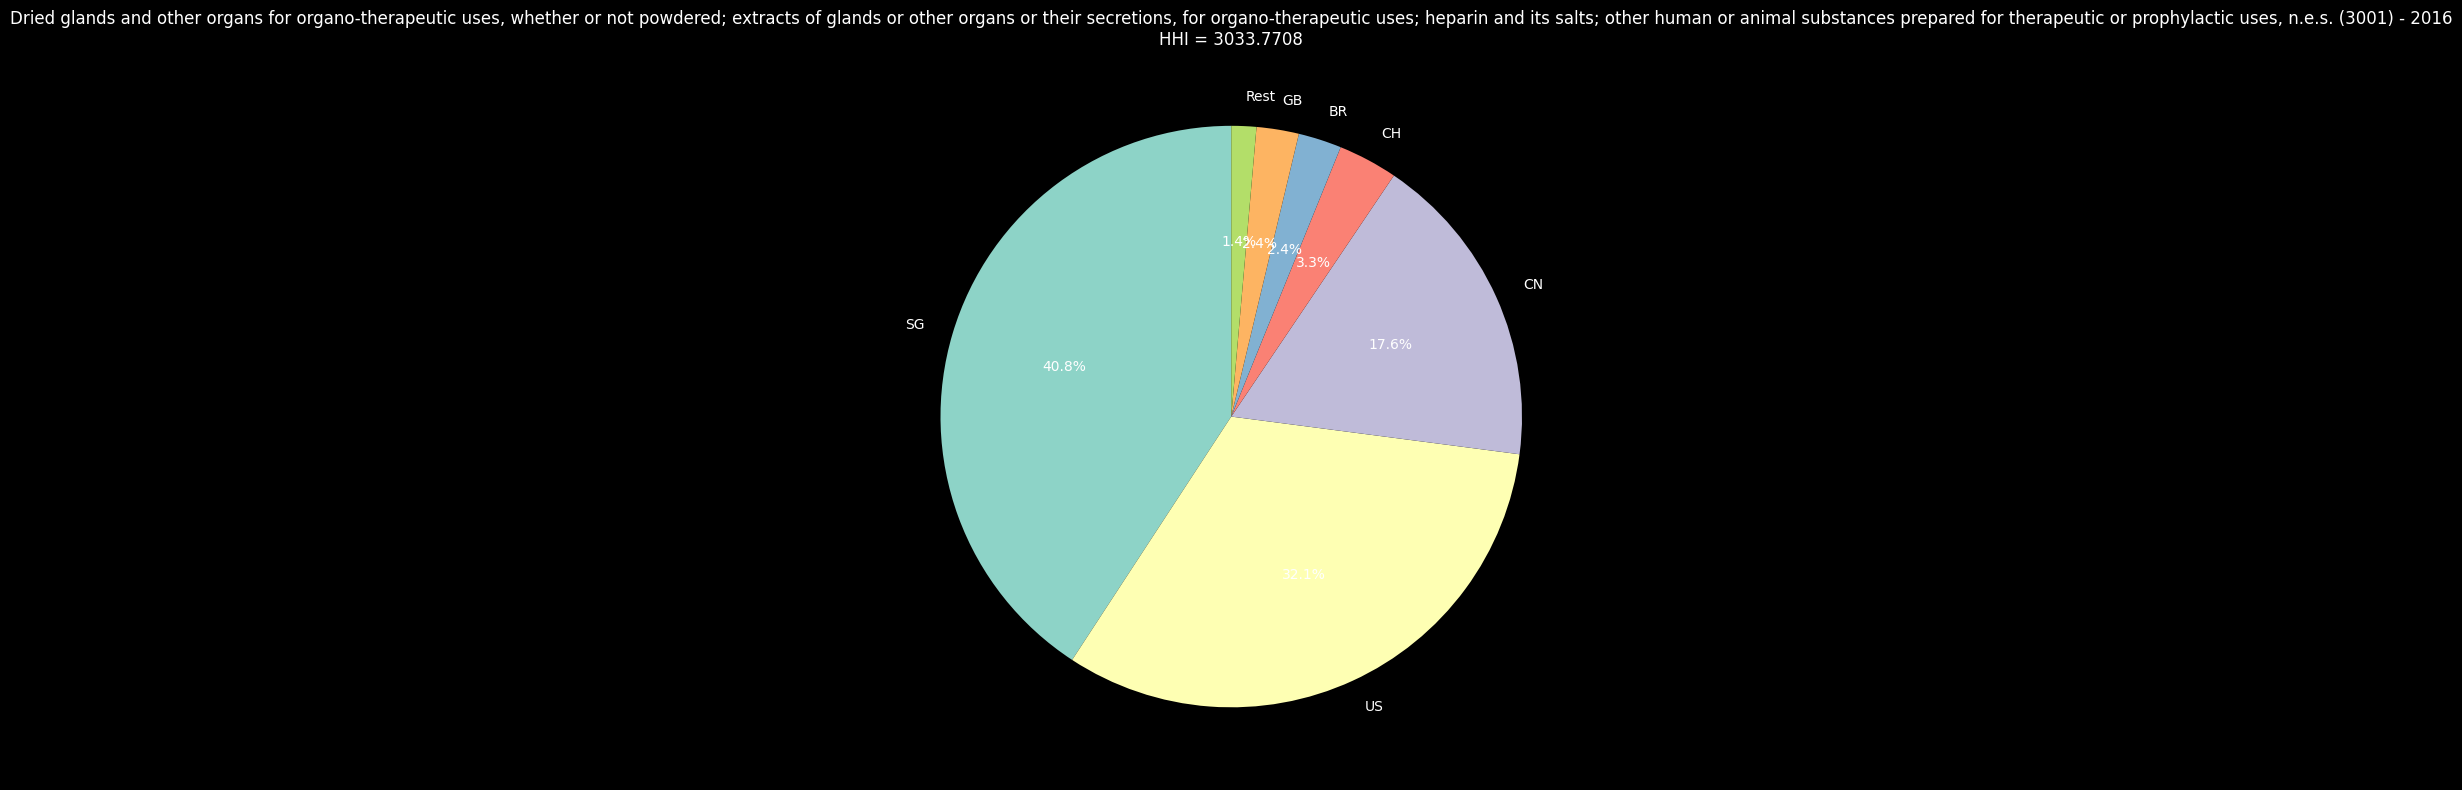

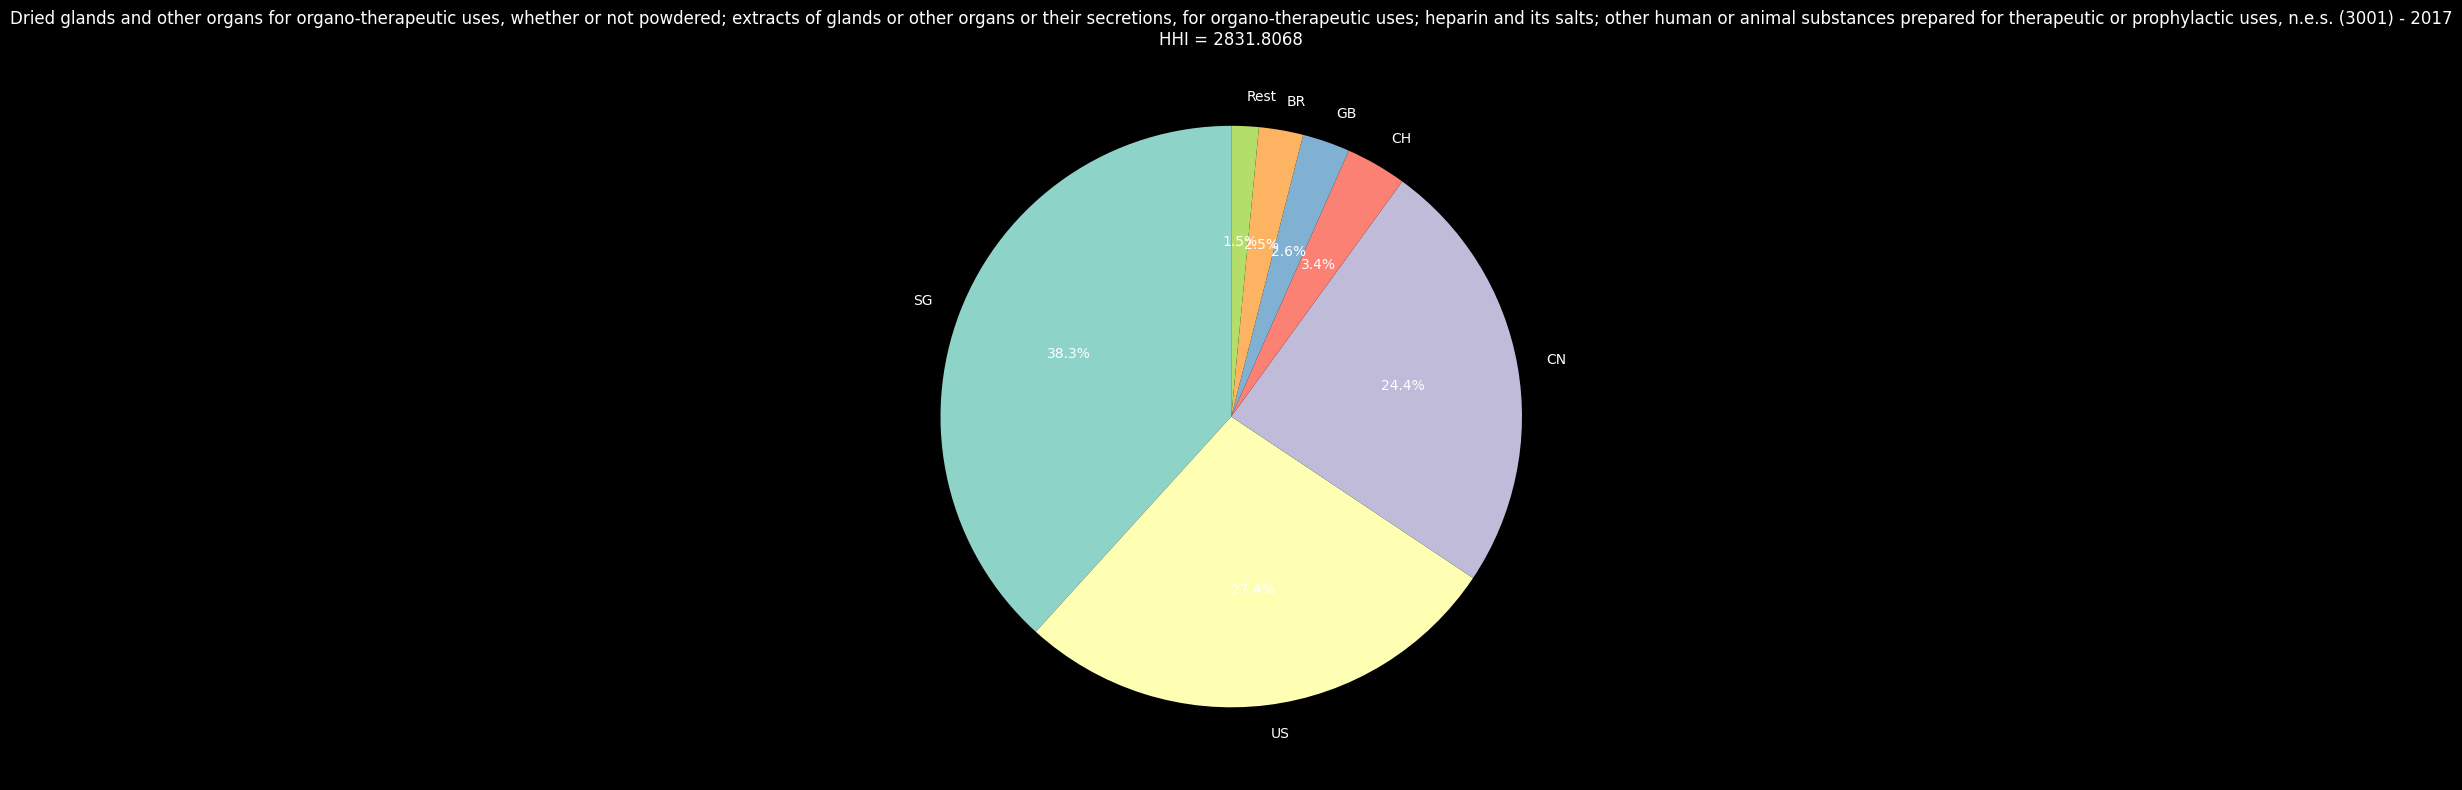

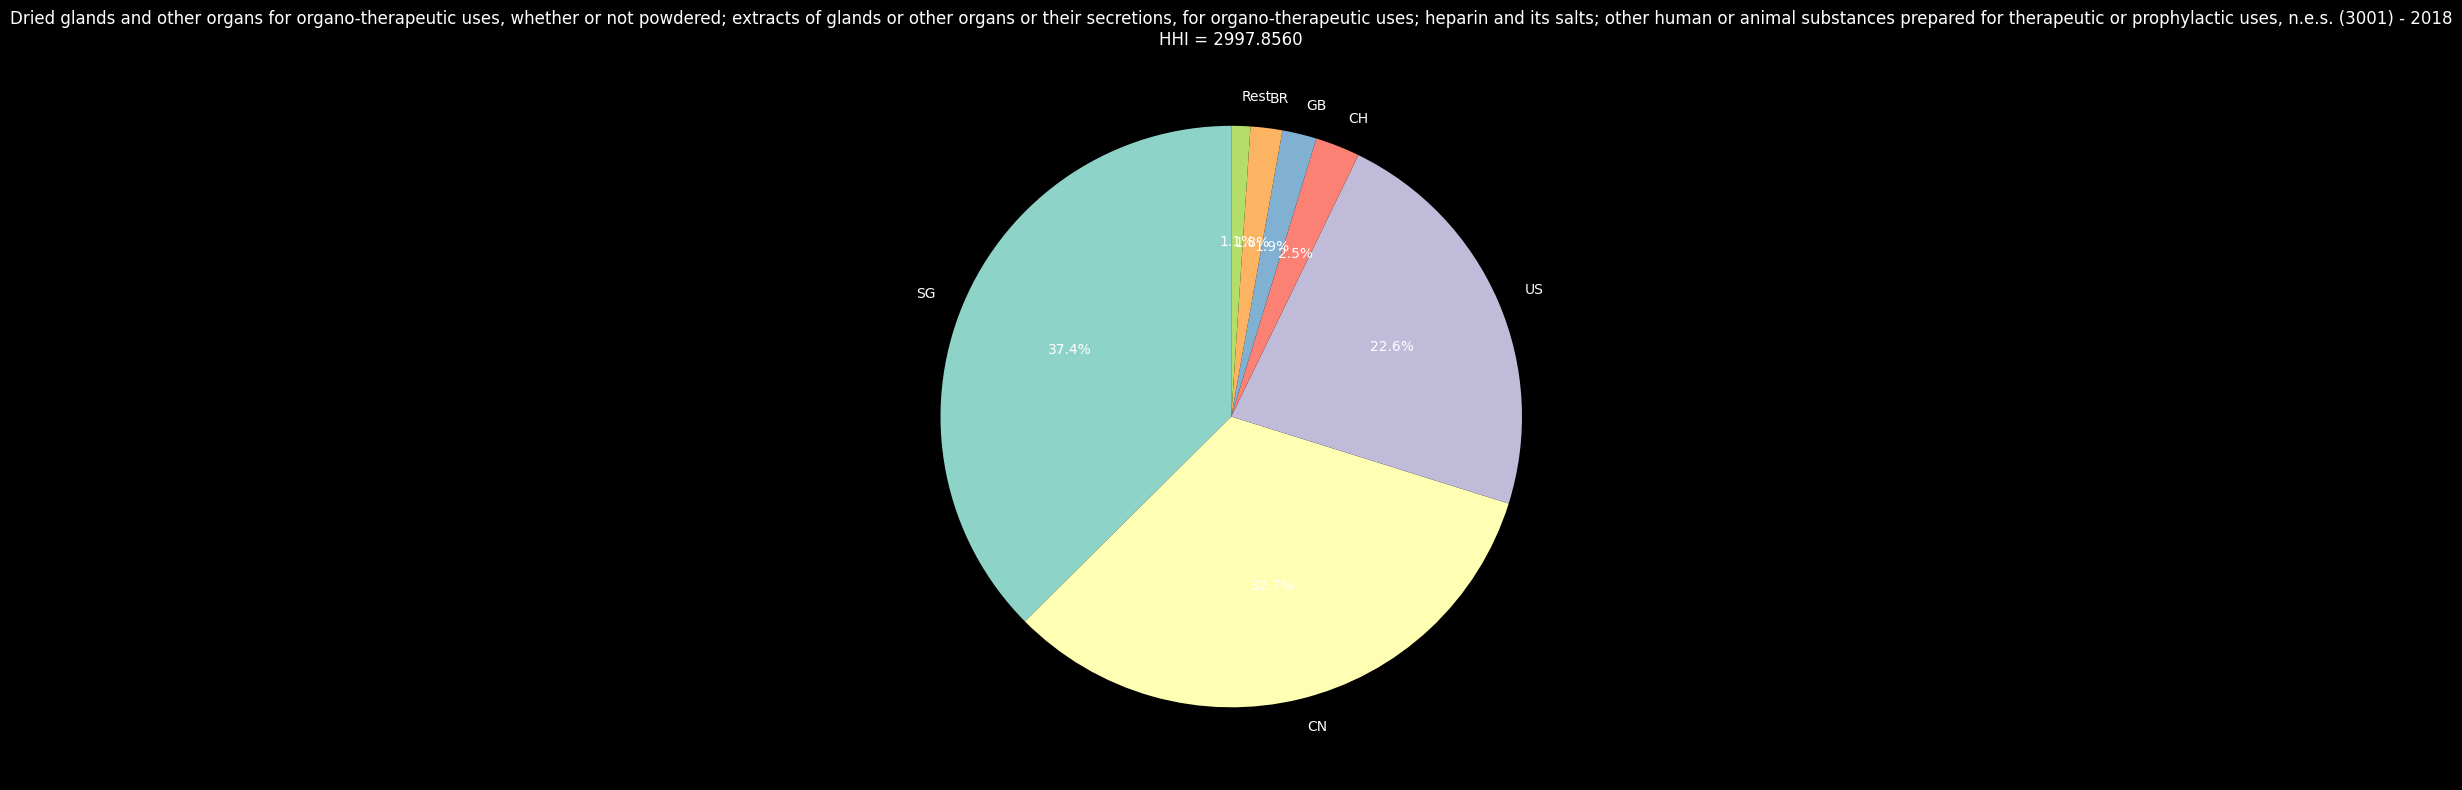

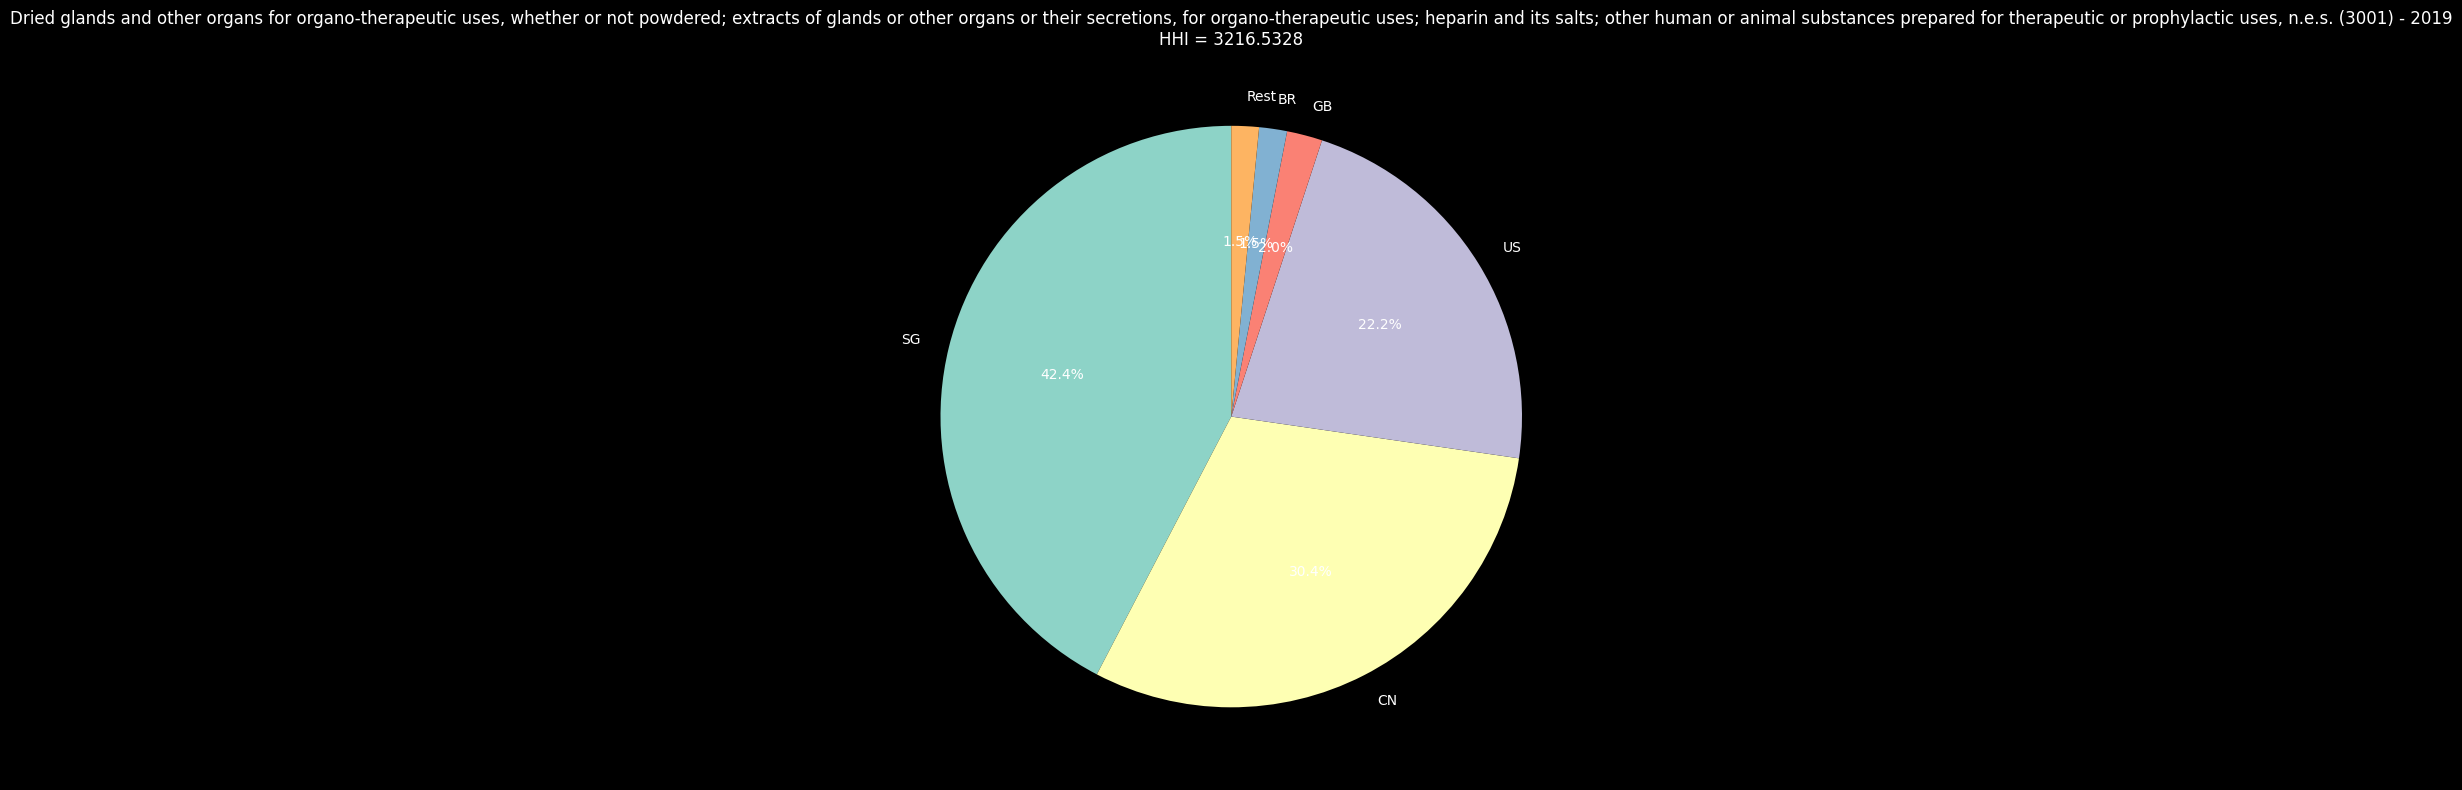

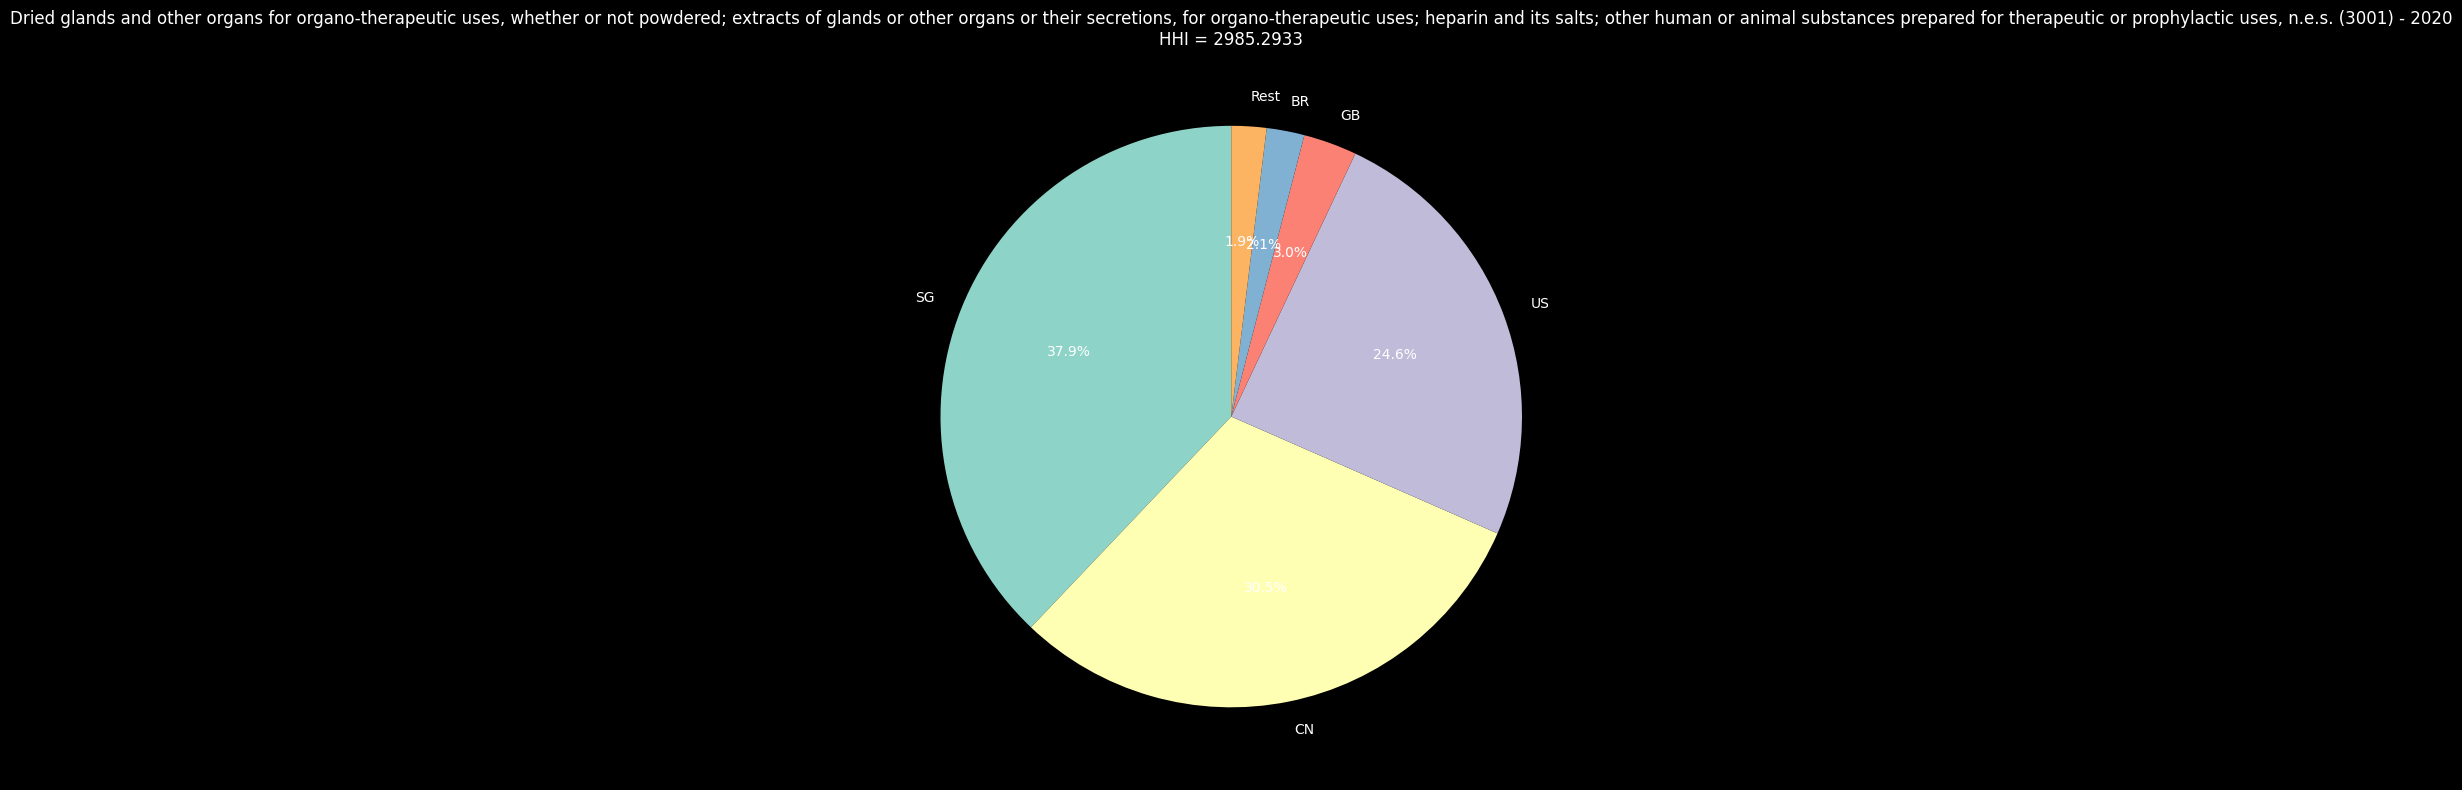

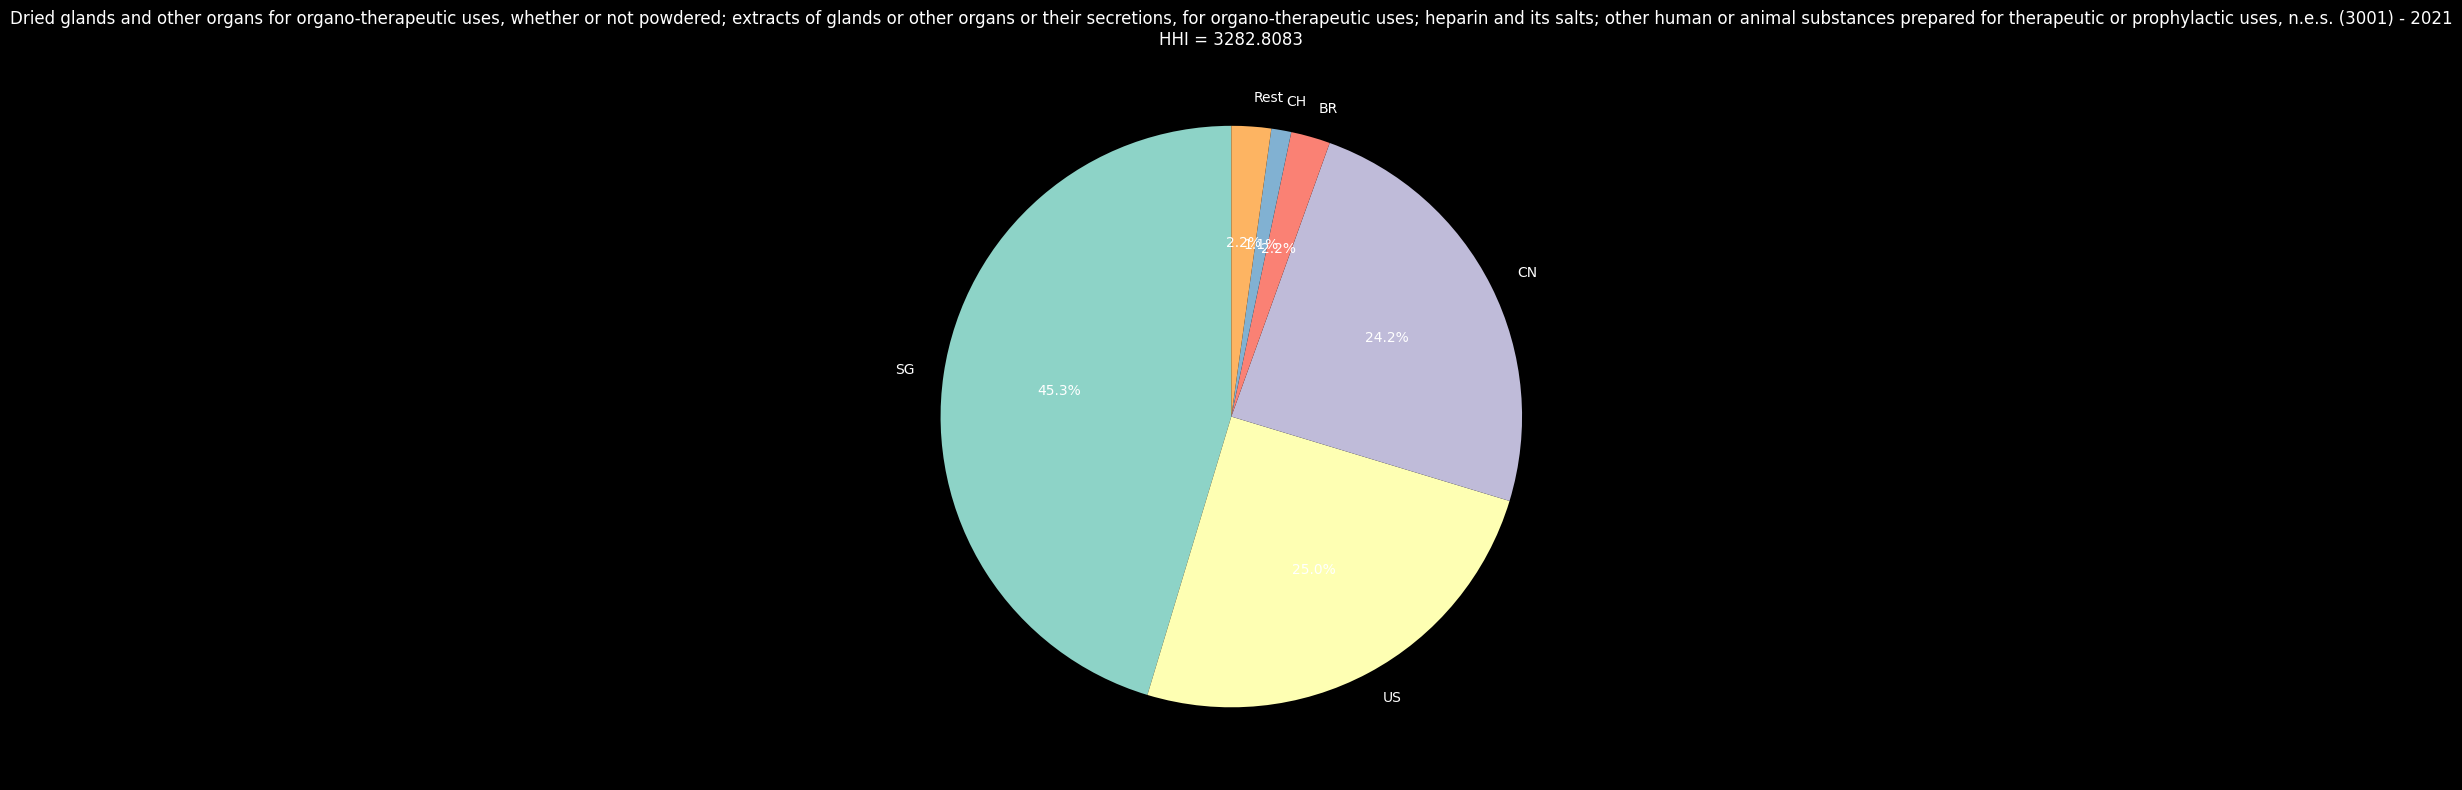

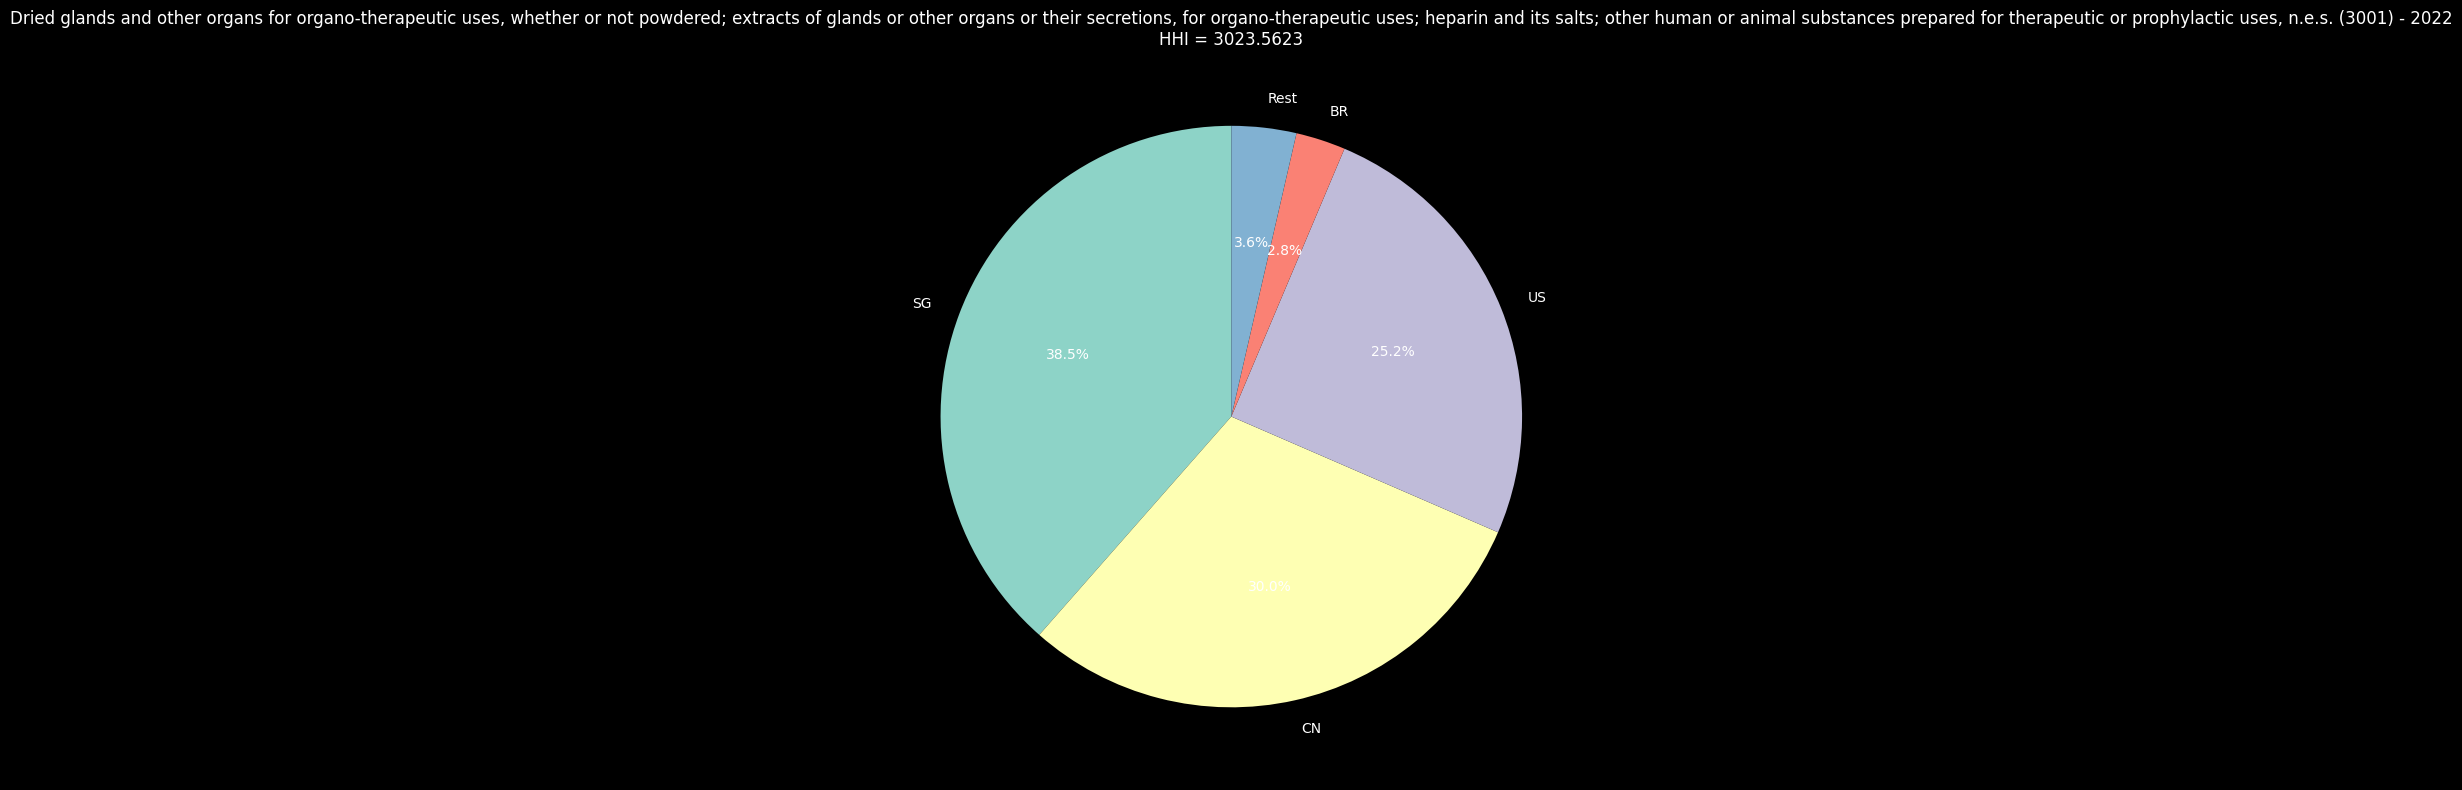

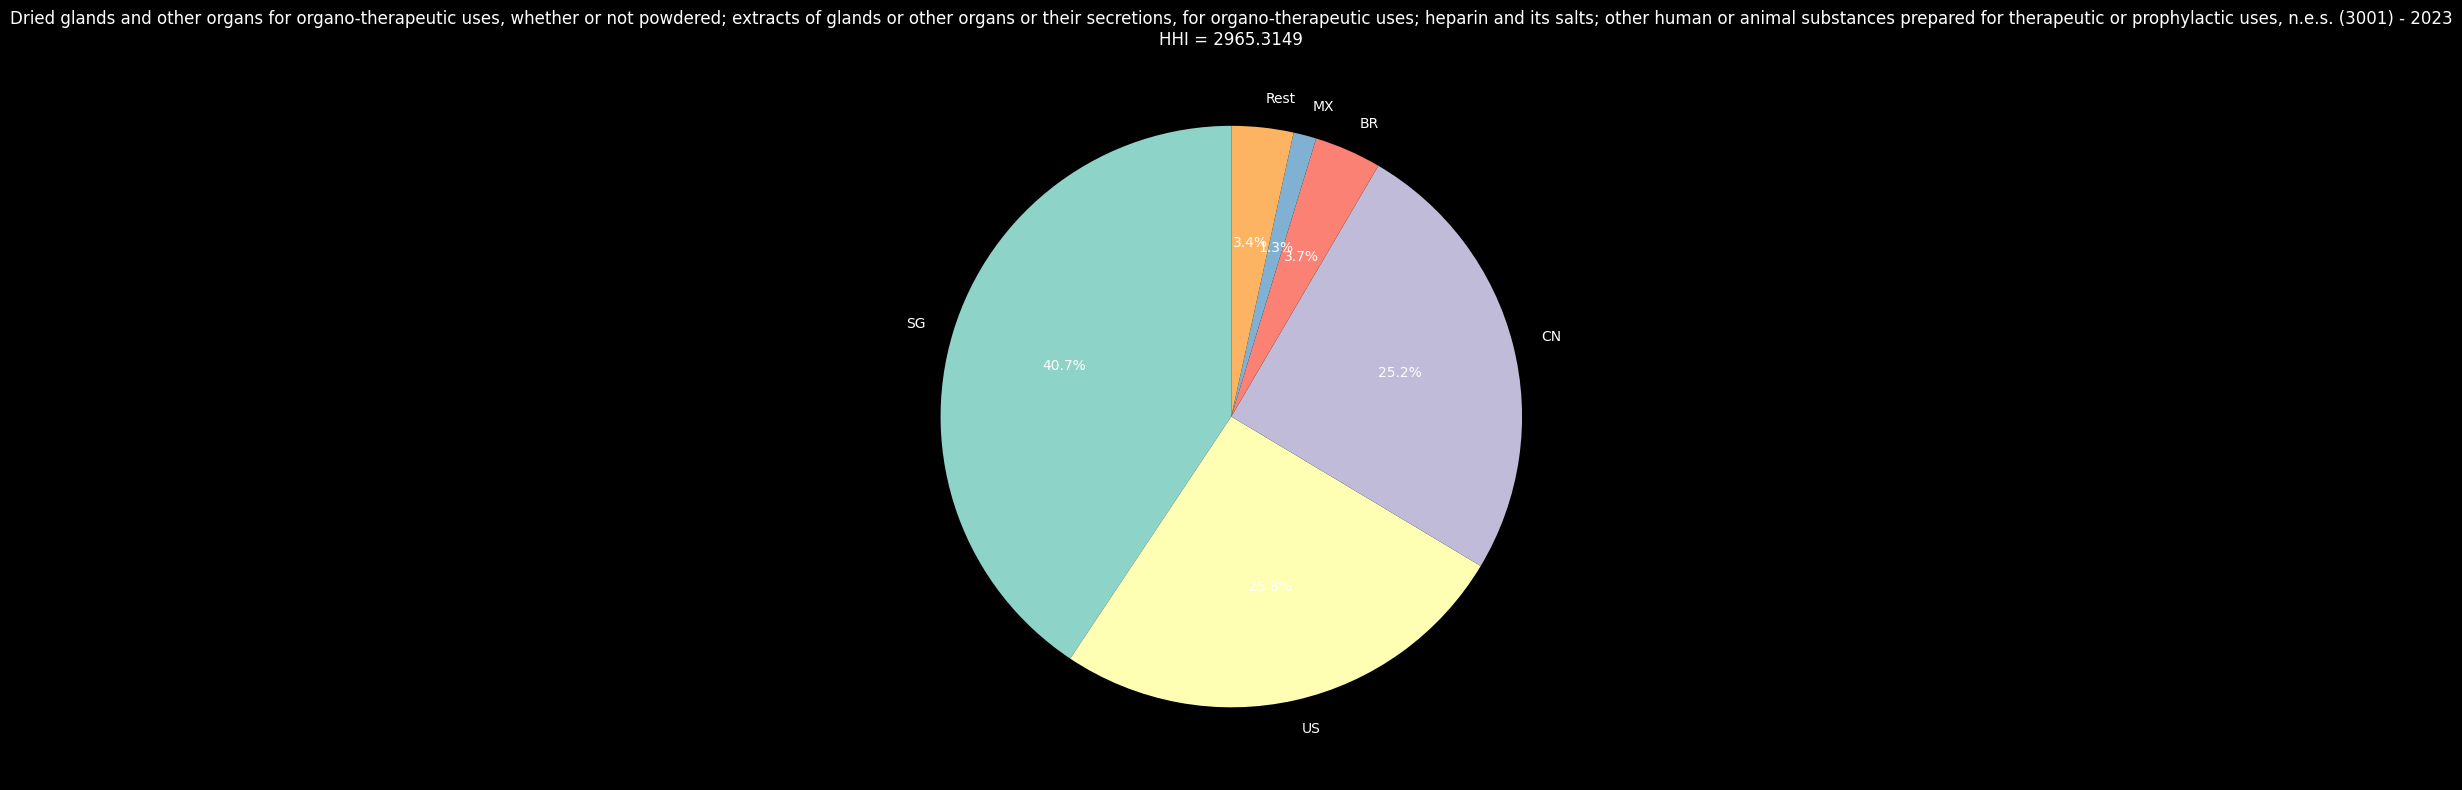

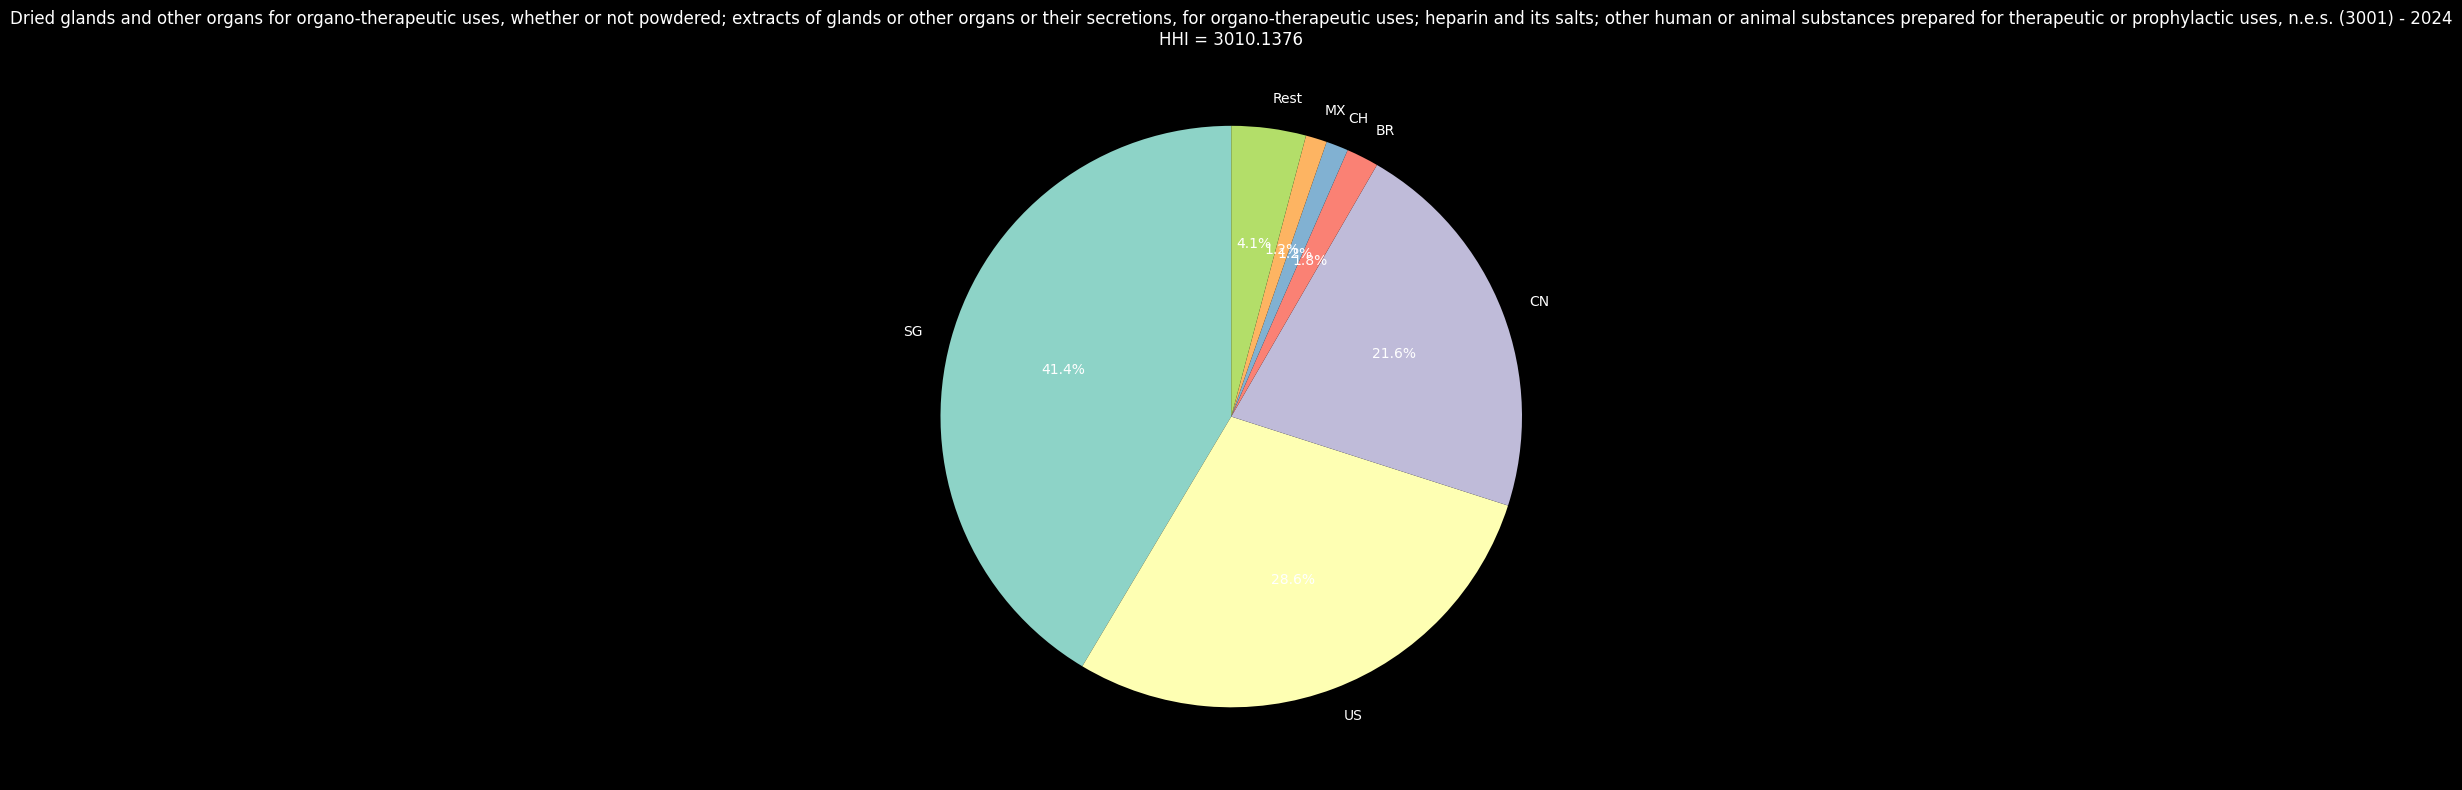

In [15]:
# Pie charts: partner breakdown for a specific product and year
for year in analysis_years:
    plot_pie(result, 3001, year, hhi_df=hhi)

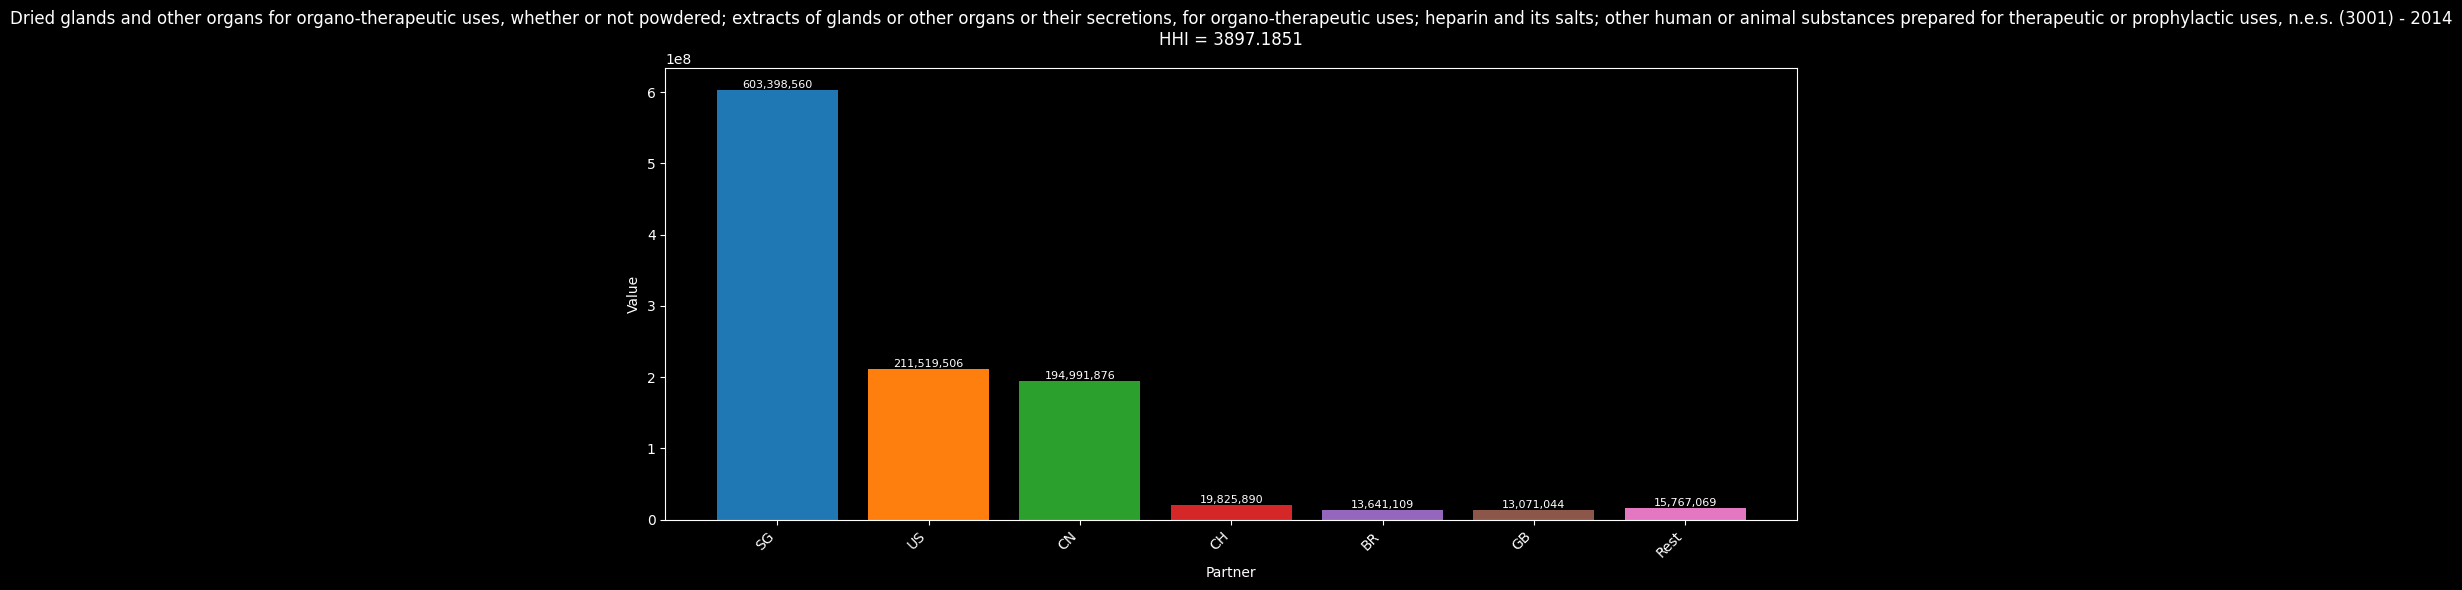

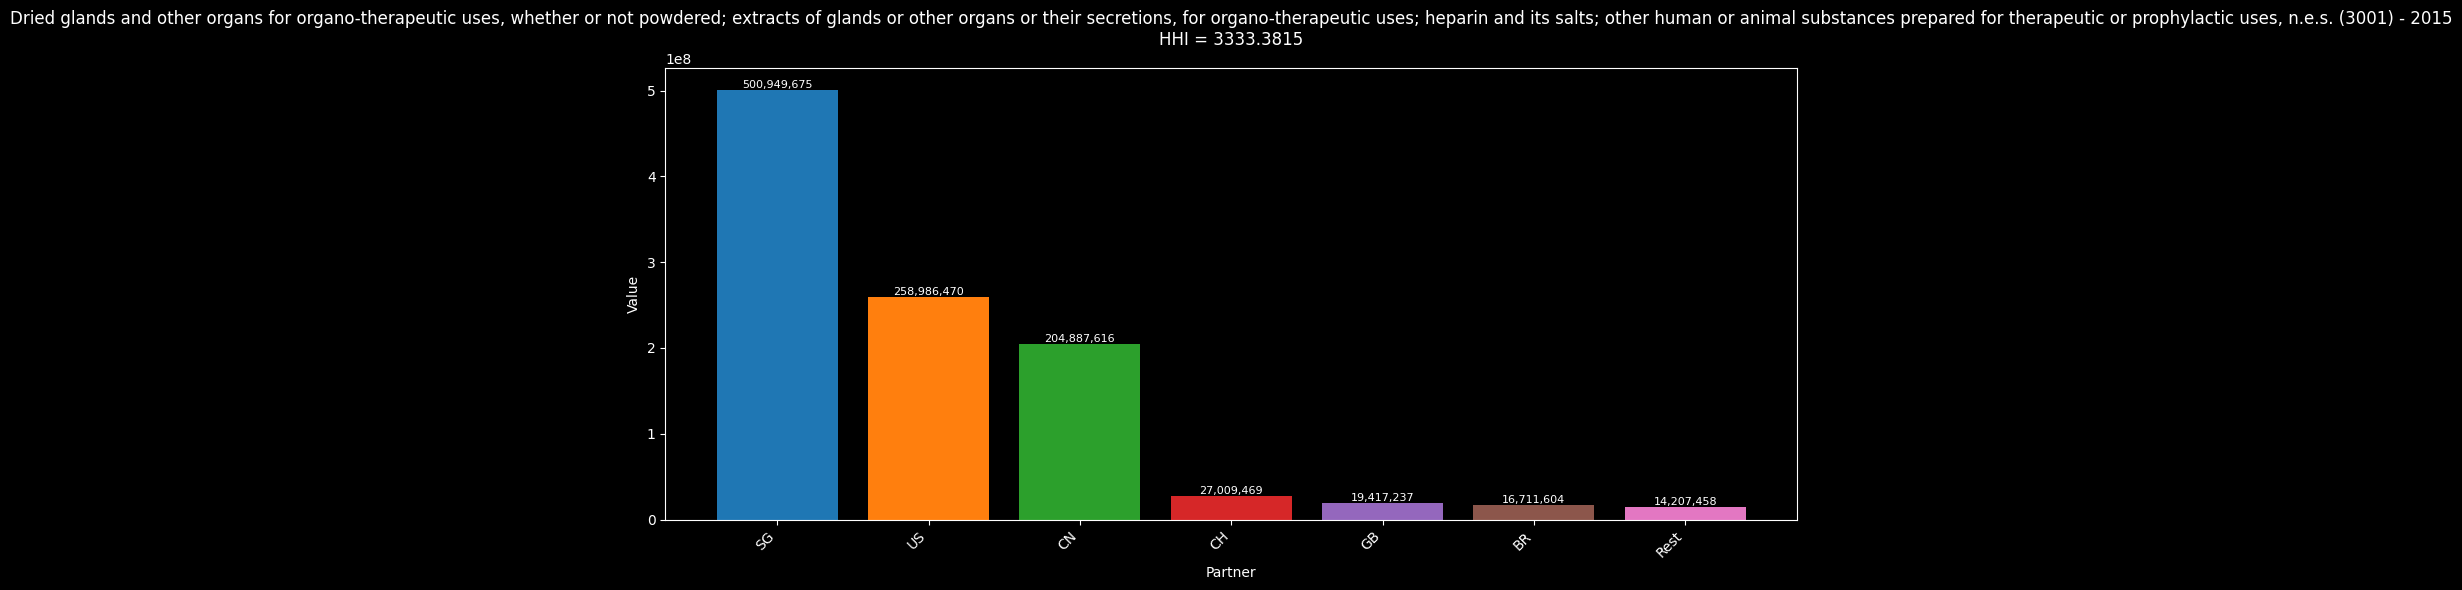

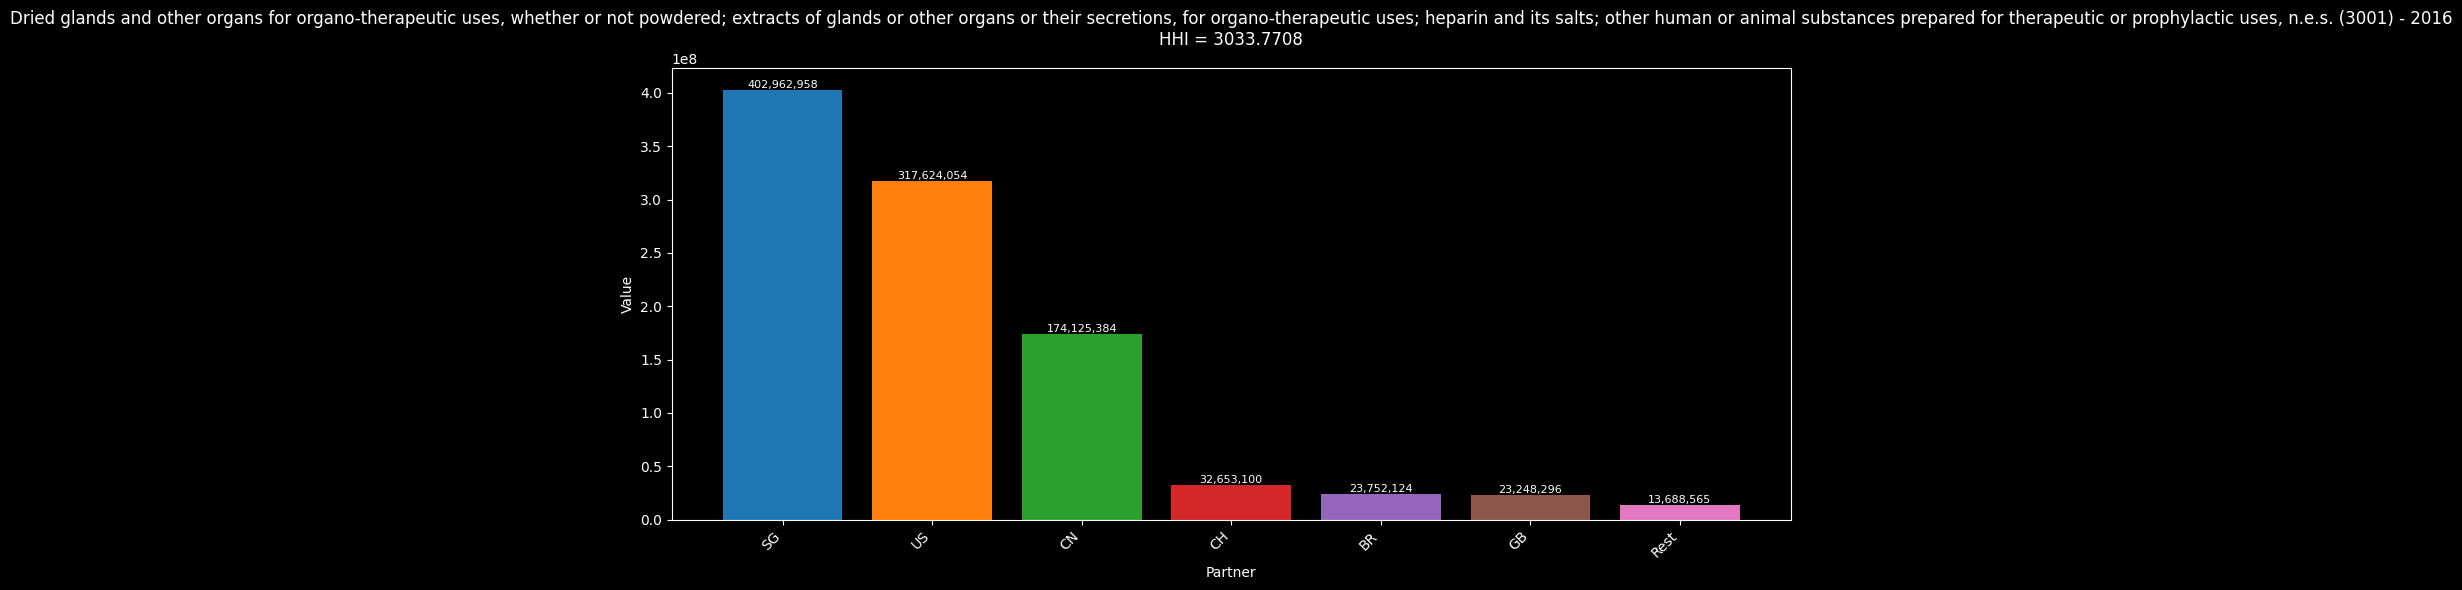

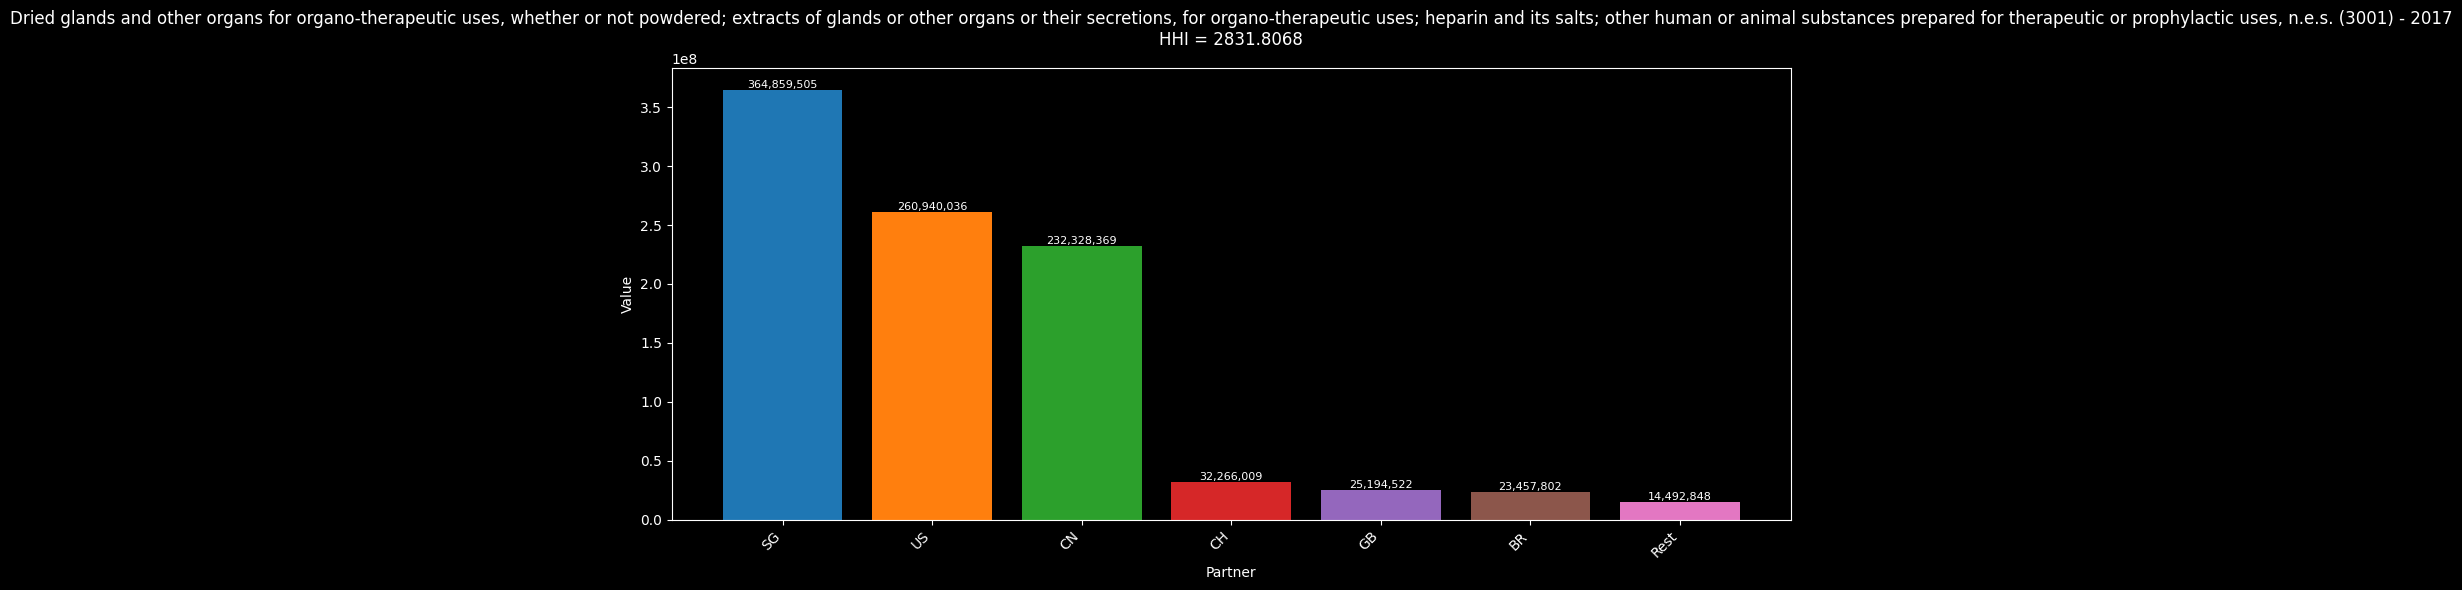

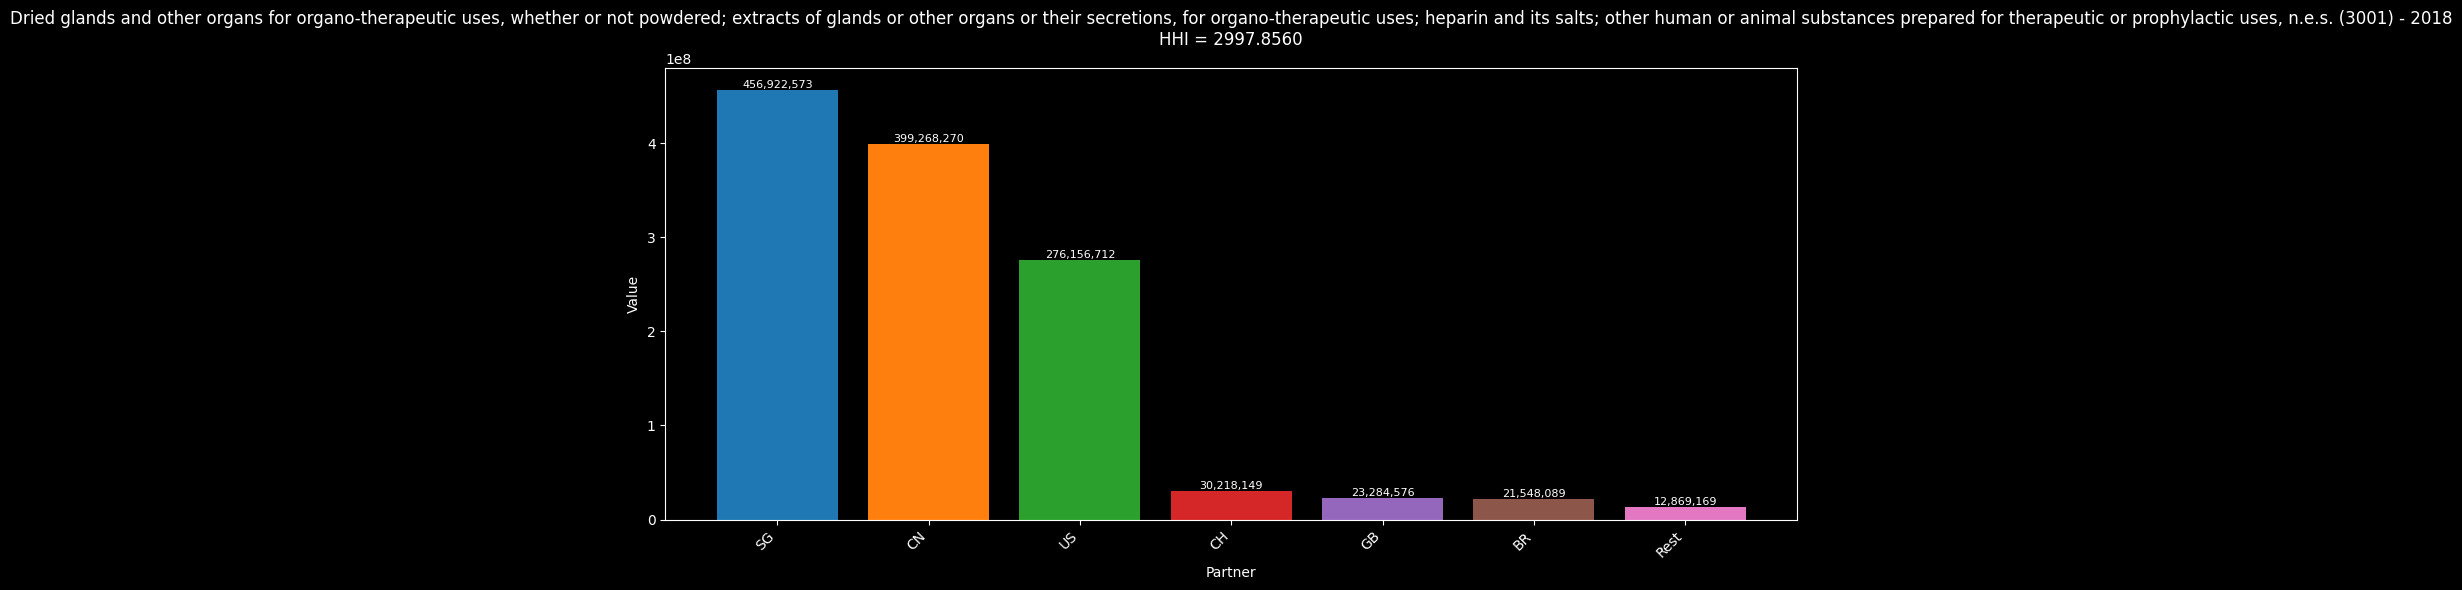

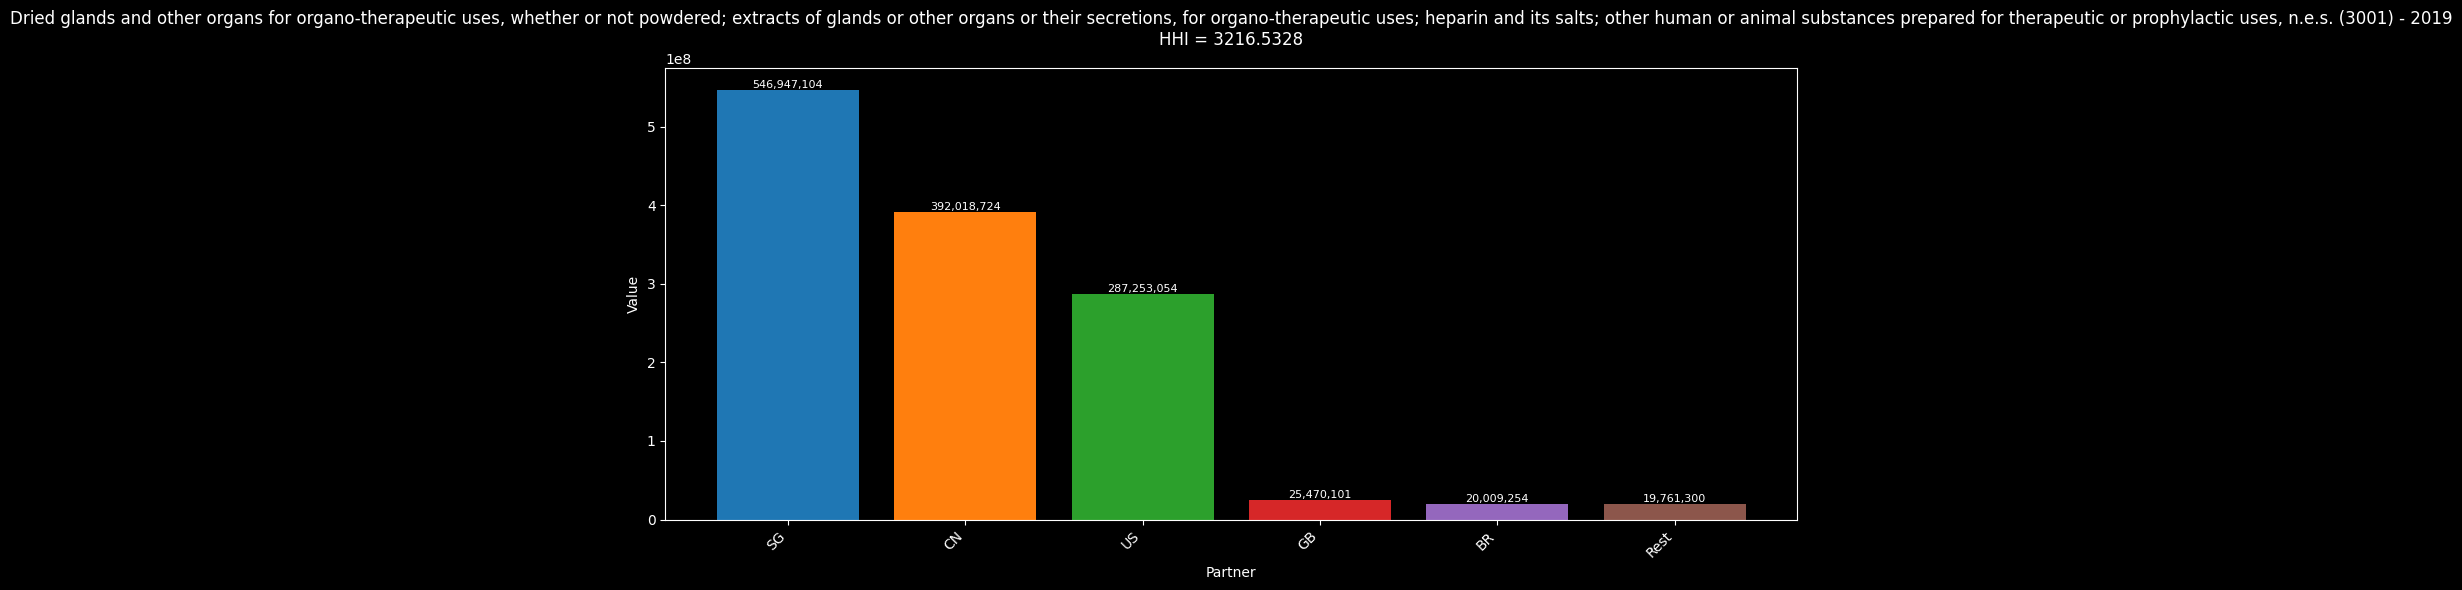

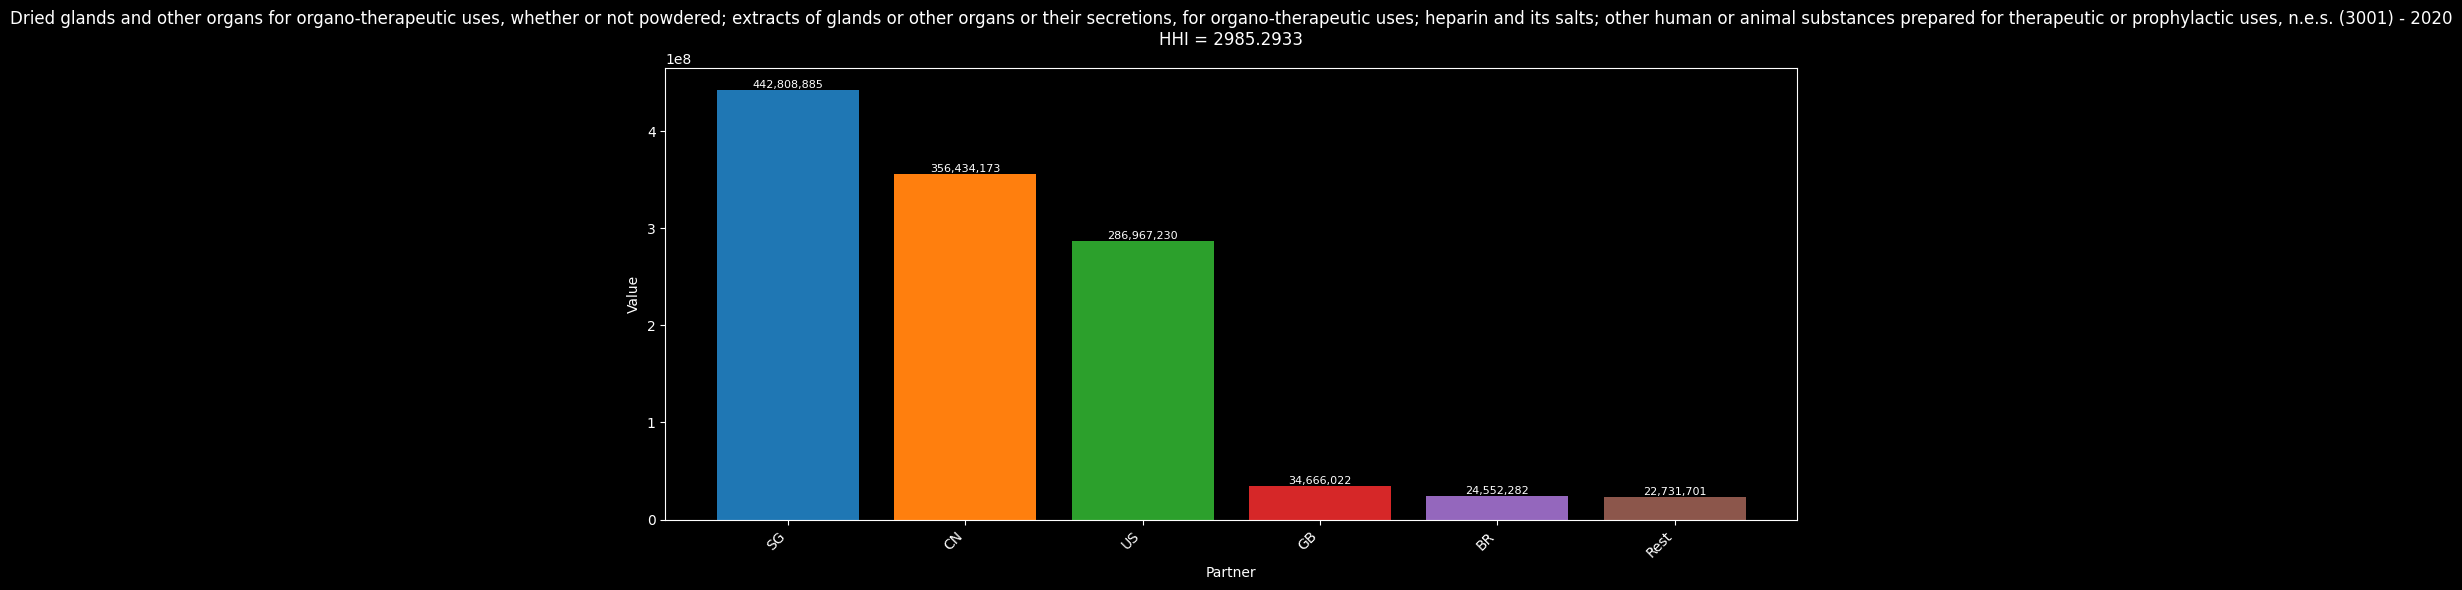

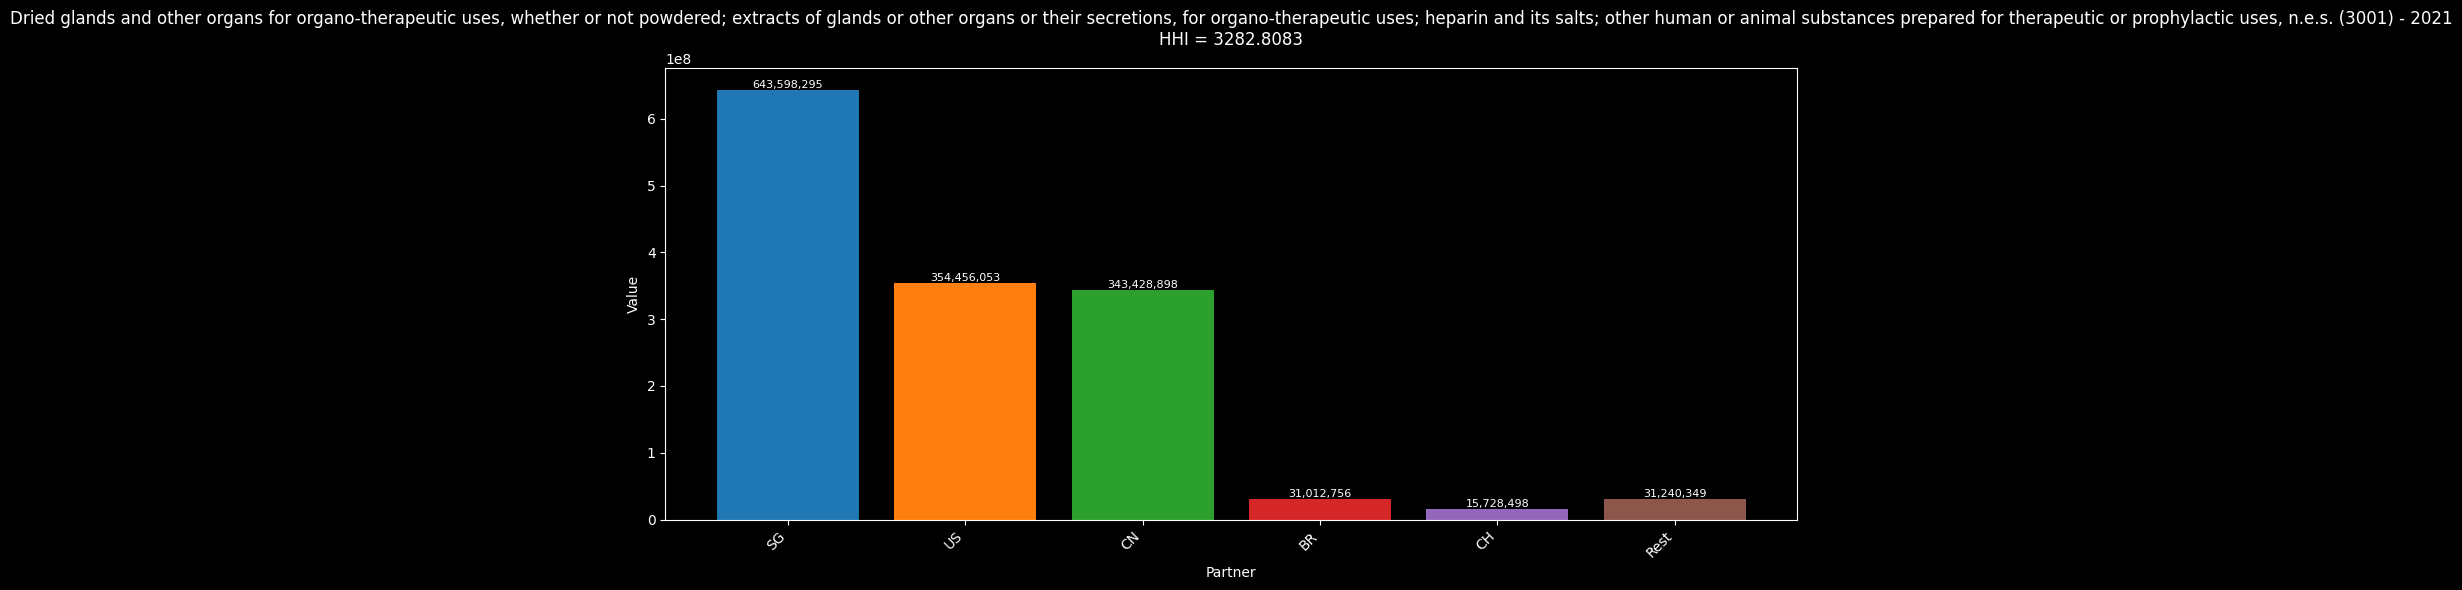

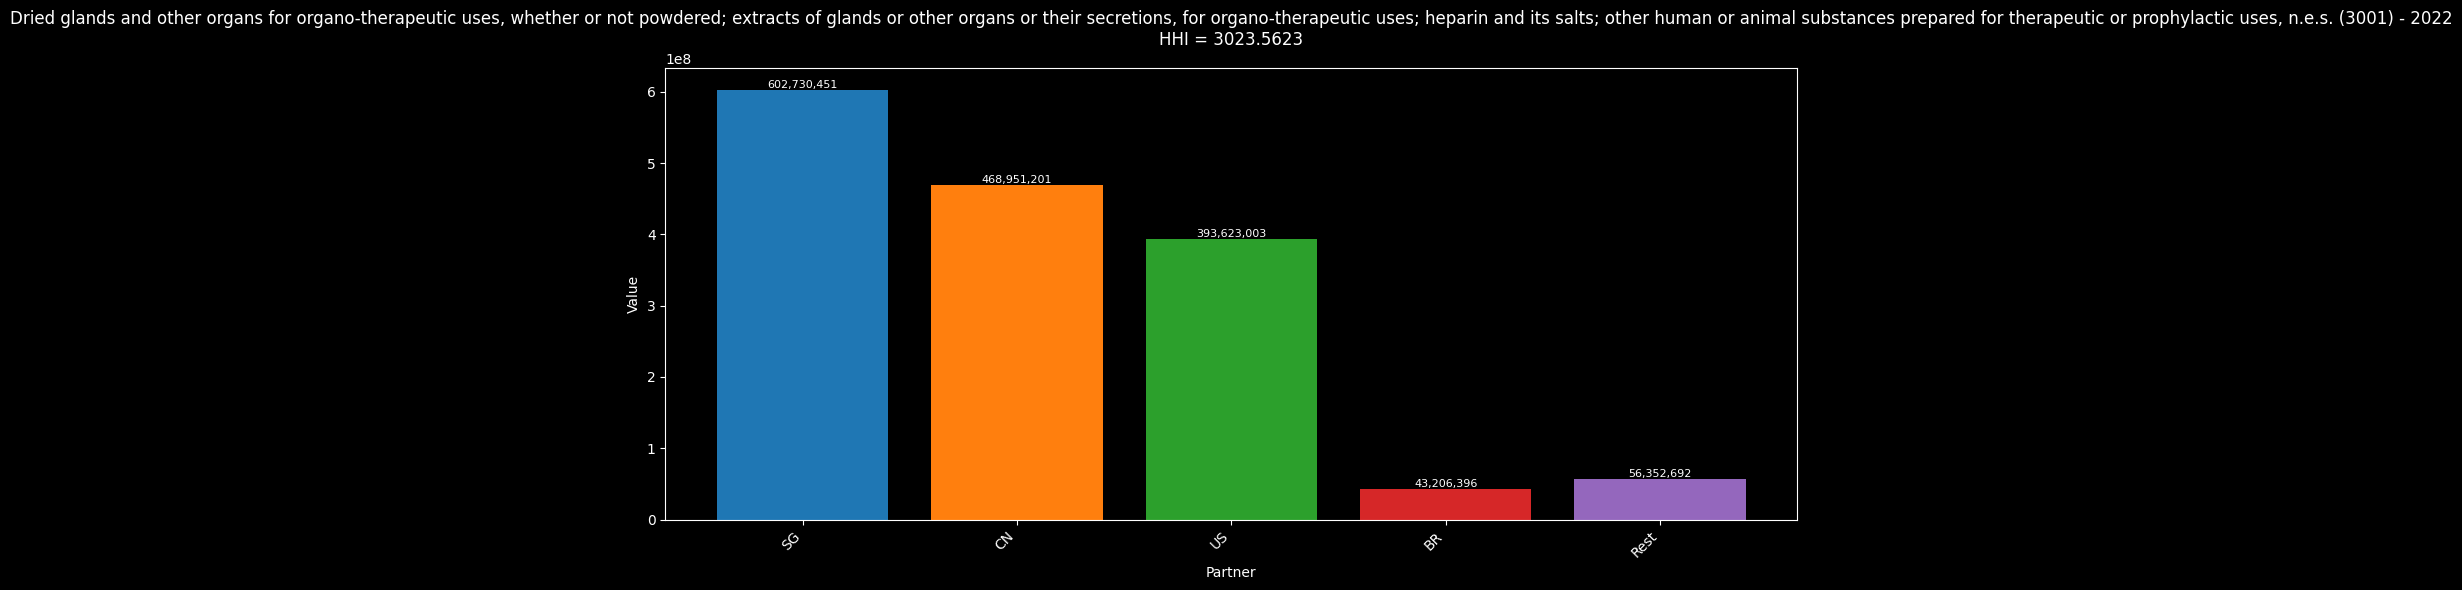

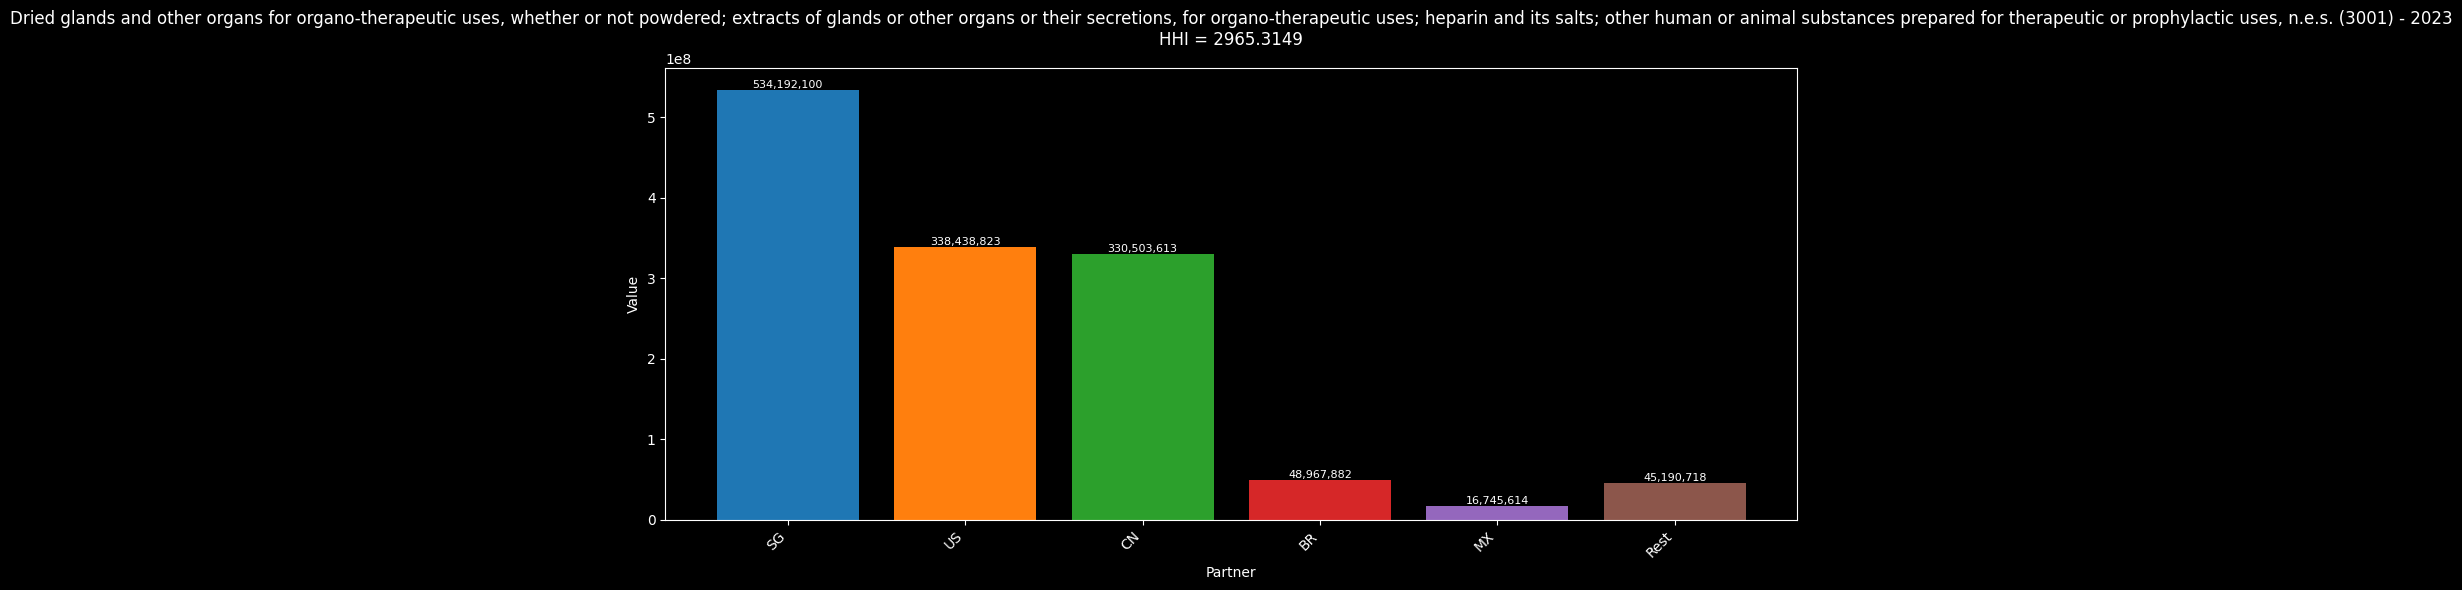

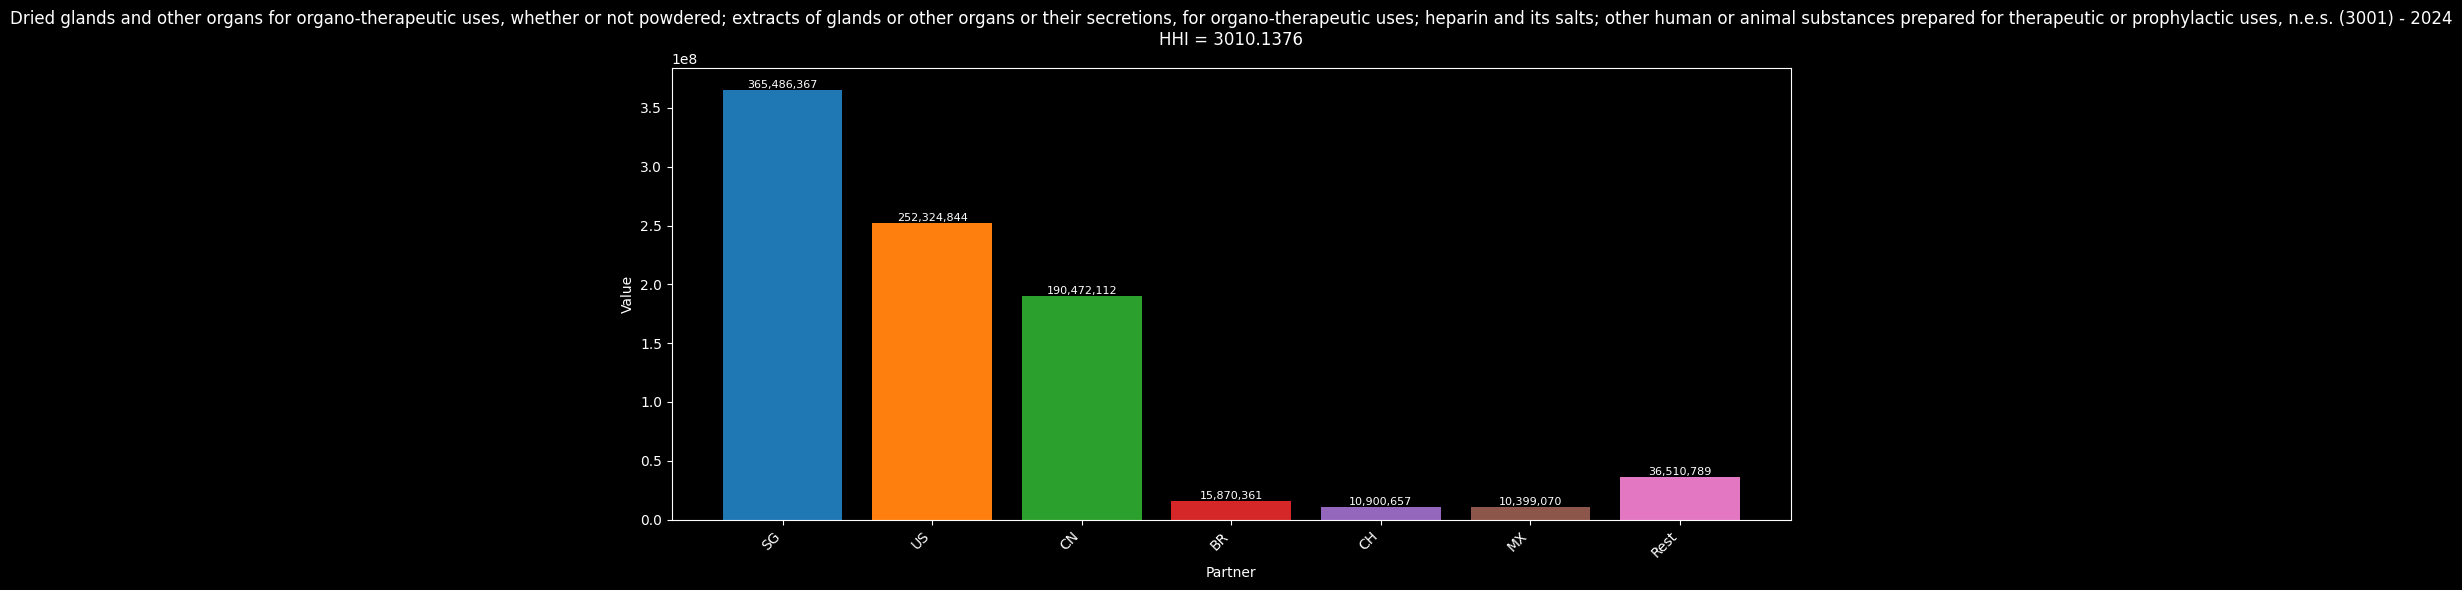

In [16]:
# Bar charts: partner trade values for a specific product and year
for year in analysis_years:
    plot_bar(result, 3001, year, hhi_df=hhi)

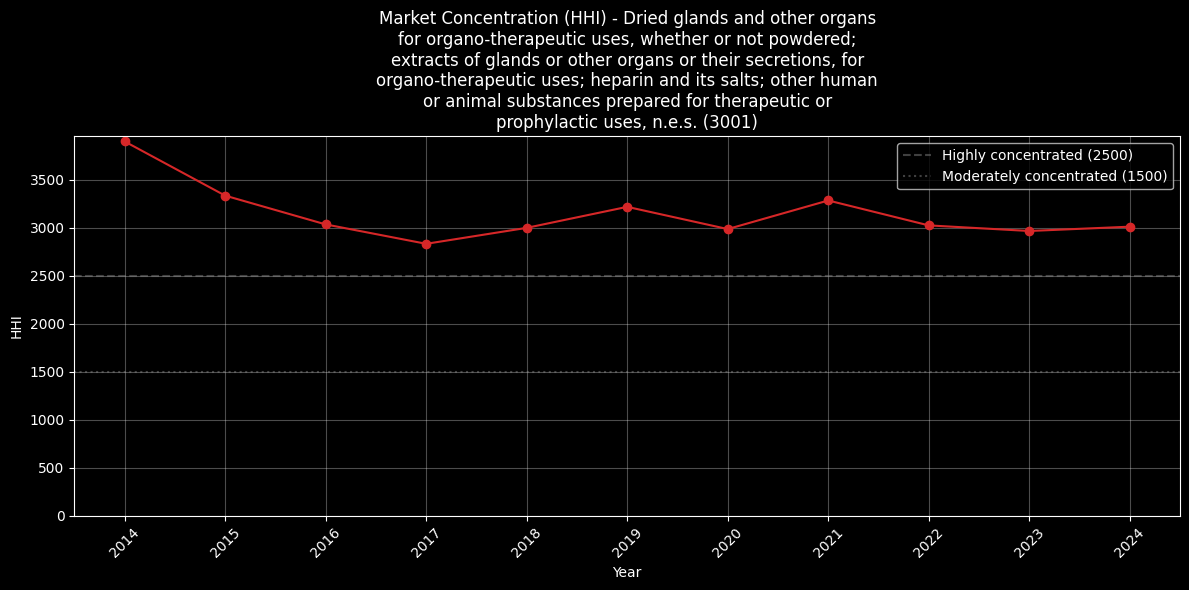

In [17]:
# HHI concentration over time for each product
code = 3001
name = result.filter(pl.col("product_code") == code)["product_name"][0]
plot_hhi_over_time(hhi, code, product_name=name)